In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import AngleEmbedding, AmplitudeEmbedding


In [2]:
# U='U_TTN'
# U_p=2
# U='U_9'
# U_p=2
# U='U_15'
# U_p=4
# U='U_13'
# U_p=6
# U='U_14'
# U_p=6
U='U_SO4'
U_p=6
# U='U_5'
# U_p=10
# U='U_6'
# U_p=10
# U='U_SU4'
# U_p=15

totol_params=2*U_p+2


torch.manual_seed(42)
np.random.seed(42)


os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate
batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

temp = 5
alpha = 0.5

In [3]:
train_f=[[320, 326, 427, 440, 451, 464, 519, 527, 662, 818, 1076, 1304, 1349, 1367, 1479, 1530, 1600, 1877, 1969, 2009, 2253, 2617, 2642, 2729, 2746, 2782, 2839, 2919, 2975, 3016, 3309, 3367, 3391, 3888, 4009, 4485, 4532, 4686, 4852, 4931, 4985, 5052, 5053, 5096, 5144, 5288, 5330, 5368, 5468, 5541, 5560, 5627, 5646, 5690, 5730, 5830, 5932, 6023, 6065, 6076, 6113, 6292, 6332, 6367, 6421, 6593, 6614, 6700, 6708, 6737, 6768, 6883, 6987, 7130, 7203, 7247, 7271, 7548, 7728, 7753, 7807, 7813, 7981, 8003, 8134, 8147, 8273, 8355, 8531, 8540, 8612, 8682, 9047, 9195, 9456, 9505, 9675, 9687, 9688, 9753, 9840, 9881, 9890, 9965, 9983, 10107, 10128, 10384, 10488, 10732, 10859, 11052, 11391, 11409, 11620, 11746, 11779, 11780, 11791, 11860, 11902, 11973, 12057, 12107, 12142, 12150, 12168, 12205, 12504, 12553, 12662, 12765, 12947, 13081, 13126, 13344, 13528, 13685, 13874, 14137, 14282, 14412, 14820, 14919, 14965, 15017, 15046, 15108, 15160, 15242, 15344, 15524, 15542, 15621, 15765, 15795, 15825, 15882, 15883, 15890, 15910, 16238, 16363, 16518, 16543, 16598, 16749, 16758, 16787, 16817, 16921, 17108, 17187, 17322, 17335, 17519, 17838, 17871, 17930, 18137, 18247, 18412, 18461, 18464, 18471, 18718, 18725, 18737, 18759, 18794, 19203, 19261, 19292, 19407, 19554, 19689, 19760, 19772, 19974, 20139, 20225, 20349, 20407, 20471, 20531, 20537, 20591, 20608, 20928, 20983, 21137, 21308, 21343, 21353, 21413, 21576, 21586, 21600, 21614, 21736, 21759, 21971, 21996, 22048, 22159, 22196, 22297, 22405, 22429, 22436, 22749, 22910, 23305, 23557, 23616, 23662, 23739, 24069, 24081, 24225, 24320, 24346, 24445, 24476, 24529, 24537, 24615, 24629, 24807, 24842, 24896, 25022, 25051, 25101, 25167, 25252, 25312, 25325, 25518, 25576, 25629, 25750, 25814, 25932, 25952, 25980, 26103, 26176, 26191, 26619, 26818, 26903, 27050, 27092, 27281, 27411, 27446, 27544, 27547, 27603, 27620, 27633, 27697, 27805, 27820, 27982, 28024, 28122, 28323, 28412, 28489, 28540, 28543, 28973, 28993, 29203, 29243, 29250, 29263, 29405, 29446, 29809, 30037, 30156, 30196, 30388, 30548, 30653, 30700, 30955, 31020, 31079, 31154, 31272, 31350, 31604, 31995, 32009, 32109, 32605, 32843, 32899, 33066, 33173, 33238, 33253, 33302, 33350, 33536, 33665, 33677, 33723, 33844, 34016, 34345, 34416, 34440, 34508, 34562, 34580, 34582, 34737, 34773, 34867, 34958, 34999, 35039, 35063, 35074, 35107, 35275, 35282, 35302, 35465, 35502, 35516, 35712, 35739, 35775, 35778, 35973, 35999, 36506, 36519, 36564, 36734, 36797, 36824, 36842, 37043, 37543, 37619, 37738, 37739, 37744, 37752, 37917, 37950, 38035, 38054, 38139, 38212, 38232, 38412, 38599, 38903, 39321, 39498, 39612, 39811, 40241, 40280, 40340, 40396, 40418, 40421, 40454, 40471, 40486, 40611, 40633, 40648, 40649, 40746, 40803, 40859, 40965, 40989, 41069, 41101, 41122, 41286, 41357, 41374, 41401, 41412, 41534, 41609, 41627, 41634, 41667, 41810, 41837, 42111, 42131, 42157, 42170, 42552, 42579, 42720, 42732, 43011, 43050, 43186, 43188, 43216, 43236, 43472, 43536, 43727, 43963, 44184, 44314, 44471, 44513, 44704, 44720, 44893, 44951, 45083, 45112, 45145, 45386, 45434, 45766, 46125, 46339, 46579, 46726, 46748, 46772, 46962, 46963, 46980, 46992, 47190, 47289, 47324, 47513, 47552, 47690, 48039, 48111, 48200, 48403, 48414, 48421, 48434, 48612, 48613, 48661, 48677, 48715, 48947, 49014, 49086, 49214, 49220, 49263, 49374, 49695, 50157, 50200, 50205, 50236, 50256, 50291, 50298, 50324, 50328, 50379, 50559, 50617, 50630, 50825, 50958, 50968, 51017, 51044, 51210, 51226, 51422, 51585, 51733, 51774, 51826, 51828, 51834, 51865, 51883, 51889, 52045, 52130, 52288, 52593, 52673, 52716, 52921, 52978, 53038, 53077, 53257, 53350, 53444, 53734, 53788, 53800, 53916, 53936, 53994, 54083, 54263, 54272, 54421, 54459, 54832, 54836, 54853, 55027, 55030, 55065, 55130, 55217, 55484, 55631, 55663, 55765, 55785, 55840, 55917, 56023, 56174, 56450, 56454, 56489, 56556, 56573, 56639, 56651, 56775, 56940, 57091, 57221, 57359, 57364, 57407, 57693, 57784, 57811, 57882, 57962, 57977, 58074, 58108, 58546, 58584, 58768, 58809, 58819, 59017, 59059, 59148, 59256, 59313, 59372, 59547, 59595, 59704, 59952, 59972], [14, 102, 112, 128, 315, 475, 556, 572, 993, 1192, 1230, 1242, 1321, 1425, 1463, 1521, 1579, 1647, 1676, 1699, 1710, 1915, 1945, 2225, 2301, 2374, 2462, 2495, 2547, 2583, 2708, 2719, 2784, 2831, 2889, 2918, 2998, 3041, 3177, 3488, 3560, 3755, 3956, 4105, 4186, 4294, 4405, 4504, 4557, 4602, 4731, 4775, 4933, 4942, 4971, 5006, 5073, 5132, 5149, 5225, 5235, 5271, 5425, 5439, 5484, 5789, 5983, 6002, 6104, 6208, 6262, 6277, 6365, 6395, 6745, 6783, 6822, 6851, 7020, 7131, 7303, 7345, 7402, 7632, 7828, 7910, 8083, 8092, 8124, 8131, 8185, 8383, 8394, 8423, 8445, 8451, 8760, 8778, 8934, 8963, 9011, 9121, 9430, 9590, 9609, 9674, 9903, 10006, 10048, 10067, 10085, 10266, 10568, 10601, 10662, 10675, 10686, 11043, 11200, 11236, 11275, 11279, 11317, 11326, 11395, 11543, 11608, 11809, 11835, 11995, 12154, 12215, 12459, 12508, 12705, 12706, 12746, 12793, 12987, 13260, 13501, 13733, 13840, 13985, 13992, 14060, 14212, 14268, 14271, 14345, 14462, 14651, 14846, 14859, 14879, 14964, 14986, 14998, 15073, 15138, 15264, 15266, 15271, 15277, 15316, 15608, 15669, 15790, 15835, 15865, 15921, 15959, 16218, 16233, 16345, 16348, 16509, 16656, 16718, 16735, 16904, 17213, 17422, 17487, 17505, 17618, 17802, 17834, 17900, 18074, 18270, 18442, 18444, 18692, 18761, 18880, 18942, 18953, 19018, 19051, 19139, 19176, 19304, 19526, 19528, 19626, 19640, 19651, 19751, 19804, 19937, 20036, 20052, 20232, 20298, 20465, 20643, 20875, 20963, 21101, 21201, 21247, 21424, 21744, 21884, 21991, 22173, 22303, 22345, 22464, 22689, 22831, 22844, 22899, 22916, 22928, 23291, 23353, 23399, 23822, 23892, 23954, 24115, 24135, 24136, 24293, 24329, 24339, 24341, 24405, 24564, 24782, 24811, 24958, 25397, 25496, 25751, 25864, 25898, 25940, 25961, 26087, 26118, 26250, 26350, 26388, 26401, 26421, 26535, 26745, 26993, 27012, 27159, 27262, 27284, 27300, 27454, 27665, 27751, 27789, 27792, 27793, 27920, 27924, 28017, 28019, 28099, 28232, 28361, 28405, 28521, 28622, 28660, 28819, 28827, 28837, 28893, 28922, 28964, 28981, 29069, 29088, 29125, 29337, 29518, 29532, 29567, 29697, 29746, 29828, 30007, 30117, 30158, 30179, 30210, 30261, 30368, 30381, 30430, 30628, 30829, 30894, 30901, 30958, 30996, 31017, 31134, 31198, 31245, 31307, 31478, 31762, 31864, 31916, 32465, 32660, 32675, 32974, 32979, 33113, 33224, 33441, 33446, 33456, 33467, 33634, 33861, 33935, 34164, 34206, 34263, 34512, 34632, 34792, 35149, 35168, 35396, 35448, 35592, 35596, 35654, 35699, 35798, 35862, 35908, 36257, 36408, 36457, 36626, 36731, 36851, 36892, 37237, 37286, 37405, 37635, 37650, 37719, 37725, 37816, 37869, 38398, 38413, 38462, 38525, 38526, 38528, 38718, 38750, 38840, 38974, 38975, 38976, 39169, 39217, 39441, 39444, 39484, 39661, 39716, 39857, 39937, 40263, 40373, 40443, 40561, 40605, 40973, 41029, 41103, 41247, 41419, 41454, 41536, 41640, 41641, 41723, 41816, 41824, 41839, 41971, 42184, 42242, 42393, 42406, 42424, 42463, 42485, 42502, 42546, 42561, 42625, 42894, 42932, 43025, 43053, 43118, 43350, 43844, 43879, 43972, 44012, 44222, 44242, 44290, 44366, 44454, 44493, 44524, 44622, 44705, 44864, 44886, 44996, 45001, 45032, 45037, 45076, 45197, 45221, 45302, 45451, 45641, 45803, 46046, 46085, 46107, 46347, 46499, 47054, 47169, 47222, 47233, 47259, 47442, 47446, 47535, 47681, 47735, 47817, 48041, 48189, 48390, 48458, 48468, 48611, 48797, 49035, 49167, 49210, 49232, 49265, 49357, 49359, 49368, 49482, 49504, 49521, 49534, 49628, 50063, 50139, 50232, 50261, 50501, 50647, 50928, 51010, 51060, 51067, 51188, 51390, 51417, 51548, 51882, 52075, 52088, 52187, 52262, 52334, 52368, 52382, 52450, 52586, 52758, 52849, 53001, 53168, 53273, 53310, 53314, 53471, 53498, 53577, 53604, 53627, 53667, 53714, 53787, 53904, 53980, 54019, 54071, 54094, 54213, 54380, 54388, 54418, 54803, 54901, 54974, 55214, 55338, 55478, 55500, 55524, 55787, 55939, 56071, 56081, 56169, 56308, 56456, 56603, 56750, 56764, 56882, 57266, 57287, 57310, 57317, 57385, 57454, 57711, 57830, 57948, 58022, 58120, 58139, 58230, 58276, 58368, 58387, 58673, 58691, 58767, 58772, 58820, 58963, 58985, 58995, 59041, 59052, 59074, 59102, 59498, 59517, 59686, 59832, 59864], [28, 76, 180, 190, 199, 262, 317, 457, 588, 664, 862, 1134, 1199, 1478, 1531, 1584, 1923, 1972, 1998, 2004, 2010, 2189, 2251, 2270, 2283, 2288, 2513, 2847, 3134, 3413, 3536, 3574, 3680, 3830, 3880, 3924, 4028, 4071, 4111, 4183, 4414, 4489, 4550, 4599, 4650, 4955, 5016, 5095, 5171, 5307, 5400, 5816, 5845, 5952, 5965, 6080, 6105, 6168, 6204, 6222, 6273, 6377, 6391, 6540, 6626, 6764, 6771, 6805, 6910, 6937, 6974, 7029, 7088, 7313, 7554, 7624, 7628, 7743, 7790, 7796, 7986, 8025, 8102, 8229, 8292, 8374, 8591, 8593, 8631, 8640, 8707, 8960, 8993, 9021, 9087, 9104, 9604, 9625, 9725, 9841, 9850, 10075, 10113, 10312, 10367, 10406, 10688, 10739, 10898, 10931, 11109, 11319, 11552, 11727, 11774, 11811, 11841, 11977, 12053, 12204, 12372, 12802, 12860, 12931, 13015, 13139, 13299, 13310, 13486, 13503, 13506, 13690, 13762, 13910, 13930, 14007, 14023, 14050, 14130, 14458, 14468, 14653, 14763, 14914, 14932, 15187, 15223, 15228, 15368, 15440, 15715, 15845, 15887, 15917, 16001, 16089, 16123, 16281, 16283, 16309, 16328, 16408, 16482, 16527, 16744, 16813, 16902, 17046, 17080, 17173, 17188, 17246, 17353, 17431, 17439, 17763, 17836, 18017, 18201, 18206, 18215, 18318, 18323, 18356, 18394, 18693, 18713, 18780, 19028, 19053, 19084, 19229, 19271, 19653, 19737, 19808, 19919, 20021, 20077, 20100, 20240, 20247, 20313, 20442, 20568, 20867, 21135, 21366, 21493, 21502, 21742, 21804, 22067, 22083, 22112, 22124, 22411, 22491, 22548, 22558, 22594, 22769, 22922, 22945, 23087, 23114, 23216, 23325, 23441, 23457, 23625, 23826, 23894, 23952, 23982, 24067, 24098, 24290, 24321, 24752, 24786, 24862, 24961, 24968, 25217, 25459, 25487, 25510, 25526, 25530, 25564, 25591, 25927, 26006, 26093, 26265, 26348, 26447, 26477, 26504, 26689, 26770, 26899, 27223, 27258, 27347, 27356, 27844, 27852, 27898, 27935, 28285, 28335, 28370, 28454, 28533, 28672, 28684, 28832, 28950, 29017, 29060, 29176, 29244, 29654, 29667, 29717, 29853, 29967, 30191, 30349, 30533, 30534, 30561, 30580, 30609, 30640, 30951, 30972, 31185, 31381, 31454, 31658, 31709, 31827, 32022, 32146, 32269, 32317, 32337, 32475, 32678, 33075, 33213, 33274, 33281, 33290, 33449, 33469, 33593, 33941, 34062, 34078, 34228, 34252, 34432, 34636, 34717, 34768, 34799, 34856, 34891, 34964, 35011, 35071, 35090, 35106, 35110, 35111, 35290, 35356, 35453, 35597, 35685, 35690, 36016, 36077, 36081, 36147, 36209, 36292, 36355, 36568, 36593, 36715, 36768, 36775, 36805, 36875, 36904, 36936, 37210, 37307, 37427, 37491, 37669, 37696, 37777, 37838, 37974, 38010, 38140, 38275, 38307, 38339, 38354, 38381, 38427, 38469, 38609, 38649, 38679, 38715, 38720, 38800, 38825, 38839, 39097, 39118, 39168, 39283, 39284, 39434, 39698, 39914, 39921, 40037, 40345, 40365, 40366, 40607, 40699, 40749, 40782, 40815, 40851, 40949, 40988, 41037, 41105, 41169, 41451, 41955, 41965, 42037, 42138, 42633, 42708, 42885, 42887, 42918, 42934, 43047, 43293, 43294, 43312, 43394, 43430, 43441, 43450, 43546, 43547, 43850, 43852, 43877, 43899, 44298, 44334, 44347, 44393, 44395, 44490, 44797, 44828, 44902, 44993, 45287, 45346, 45367, 45405, 45412, 45505, 45568, 45620, 45698, 45880, 45993, 46036, 46105, 46197, 46217, 46224, 46250, 46464, 46486, 46510, 46690, 46835, 46849, 46951, 46956, 47164, 47171, 47226, 47228, 47270, 47302, 47530, 47565, 47688, 47743, 47890, 47956, 47984, 47990, 48009, 48118, 48191, 48320, 48323, 48460, 48476, 48497, 48545, 48621, 48686, 48799, 48946, 49409, 49452, 49834, 49873, 49875, 49916, 50229, 50259, 50474, 50478, 50508, 50720, 50744, 50812, 51118, 51214, 51262, 51320, 51340, 51379, 51787, 51898, 52011, 52189, 52358, 52403, 52547, 52643, 52659, 52677, 52695, 52982, 53088, 53303, 53323, 53390, 53430, 53628, 53644, 53669, 53748, 53837, 53901, 53921, 54033, 54271, 54297, 54299, 54306, 54545, 54613, 54674, 54709, 54765, 54857, 54877, 54973, 55011, 55149, 55429, 55525, 55985, 55997, 56049, 56175, 56188, 56243, 56289, 56312, 56752, 56762, 56864, 57377, 57387, 57574, 57654, 57694, 57752, 57831, 57876, 58026, 58032, 58103, 58704, 58705, 58857, 58962, 59093, 59218, 59317, 59422, 59475, 59628, 59641, 59655, 59677, 59807, 59819, 59833, 59896, 59971, 59983], [179, 356, 459, 1121, 1151, 1836, 1924, 1959, 2088, 2430, 2503, 2506, 2627, 2675, 2751, 2834, 2871, 2905, 3174, 3181, 3220, 3318, 3336, 3523, 3542, 3683, 3740, 4073, 4094, 4262, 4352, 4506, 4508, 4511, 4579, 4583, 4866, 4878, 5337, 5432, 5433, 5710, 5753, 6048, 6069, 6170, 6286, 6430, 6516, 6710, 6939, 7065, 7067, 7192, 7387, 7584, 7626, 7672, 7678, 7832, 7881, 7982, 8017, 8115, 8254, 8350, 8494, 8729, 8958, 9004, 9059, 9080, 9140, 9183, 9253, 9255, 9363, 9380, 9400, 9511, 9612, 9664, 9778, 10161, 10210, 10314, 10520, 10647, 10676, 10743, 10760, 10779, 10984, 10993, 11053, 11155, 11476, 11524, 11618, 11645, 11777, 11960, 12012, 12124, 12218, 12222, 12228, 12303, 12879, 12913, 12953, 13124, 13190, 13376, 13496, 13531, 13577, 13660, 13750, 13831, 13931, 14107, 14205, 14320, 14394, 14577, 14789, 14855, 14864, 15139, 15233, 15246, 15251, 15760, 15769, 15816, 15850, 15907, 15936, 15937, 16071, 16239, 16407, 16411, 16453, 16462, 16492, 16504, 16512, 16530, 16587, 16620, 16649, 16748, 16831, 16849, 16945, 17063, 17088, 17139, 17189, 17255, 17355, 17371, 17442, 17467, 17632, 17676, 17832, 17893, 18244, 18268, 18375, 18390, 18503, 18527, 18587, 18630, 18785, 18812, 18827, 18847, 18915, 18948, 18955, 19110, 19195, 19263, 19326, 19333, 19495, 19633, 19736, 20009, 20072, 20167, 20243, 20362, 20544, 20615, 20649, 20797, 20805, 20902, 20946, 20989, 21102, 21305, 21328, 21359, 21420, 21539, 21622, 21625, 21637, 21685, 21815, 21861, 22002, 22049, 22103, 22149, 22204, 22318, 22413, 22415, 22708, 22883, 23029, 23101, 23119, 23322, 23344, 23419, 23730, 24028, 24142, 24299, 24350, 24442, 24448, 24481, 24524, 24867, 24870, 25266, 25431, 25631, 25924, 26053, 26084, 26399, 26412, 26433, 26534, 26550, 26674, 26694, 26981, 26989, 27212, 27274, 27389, 27518, 27589, 27640, 27671, 27784, 27795, 27930, 27977, 28075, 28123, 28157, 28265, 28406, 28476, 28485, 28528, 28613, 28759, 29023, 29185, 29231, 29246, 29289, 29415, 29506, 29602, 29610, 29757, 29823, 29875, 30124, 30136, 30175, 30229, 30282, 30379, 30400, 30515, 30675, 30679, 30760, 30960, 31042, 31254, 31428, 31627, 31664, 31788, 31791, 32071, 32091, 32106, 32193, 32209, 32267, 32422, 32484, 32505, 32588, 32691, 32730, 32764, 32897, 33054, 33114, 33139, 33145, 33169, 33229, 33399, 33607, 33763, 33989, 34085, 34327, 34351, 34368, 34551, 34587, 34740, 34793, 35093, 35162, 35366, 35531, 35542, 35574, 35890, 35922, 36130, 36295, 36324, 36458, 36511, 36604, 36684, 36755, 36802, 36862, 36957, 37042, 37169, 37174, 37373, 37397, 37540, 37555, 37566, 37729, 37756, 37889, 37943, 38058, 38129, 38166, 38167, 38277, 38580, 38687, 38714, 38797, 38827, 39099, 39366, 39397, 39461, 39489, 39706, 39728, 40055, 40184, 40185, 40254, 40281, 40447, 40520, 40550, 40691, 40858, 40892, 41053, 41067, 41165, 41391, 41619, 41653, 41720, 41943, 42024, 42041, 42114, 42120, 42210, 42343, 42636, 42906, 42962, 43067, 43076, 43100, 43126, 43208, 43252, 43353, 43393, 43456, 43666, 43672, 43747, 43758, 43759, 44216, 44380, 44439, 44497, 44522, 44906, 45008, 45088, 45164, 45171, 45328, 45365, 45398, 45407, 45517, 45563, 45687, 45704, 45712, 45774, 45786, 45809, 45848, 45902, 45903, 45945, 45970, 46061, 46079, 46350, 46403, 46465, 46485, 46709, 46834, 46882, 46899, 46923, 47027, 47090, 47287, 47533, 47678, 47834, 47872, 47913, 48291, 48324, 48336, 48360, 48415, 48482, 48551, 48628, 48859, 48935, 49006, 49254, 49307, 49585, 49729, 49810, 49912, 50067, 50214, 50253, 50260, 50286, 50679, 50922, 51085, 51268, 51388, 51421, 51571, 51706, 51837, 51871, 51915, 51998, 52371, 52379, 52585, 52607, 52679, 52690, 52828, 52871, 53035, 53084, 53123, 53231, 53374, 53619, 53995, 54013, 54029, 54228, 54273, 54322, 54339, 54343, 54499, 54867, 54898, 55051, 55054, 55151, 55419, 55432, 55592, 55715, 55743, 55845, 55914, 55932, 55947, 55974, 55998, 56012, 56515, 56578, 56616, 56721, 56754, 56817, 56823, 56871, 57004, 57040, 57195, 57247, 57312, 57441, 57457, 57488, 57492, 57635, 57734, 57739, 57886, 57932, 58079, 58343, 58410, 58503, 58527, 58564, 58640, 58747, 58855, 58878, 59001, 59202, 59263, 59282, 59299, 59308, 59318, 59322, 59383, 59643, 59715, 59735, 59818, 59886], [20, 89, 163, 166, 275, 354, 373, 414, 585, 718, 742, 749, 990, 1004, 1030, 1258, 1345, 1633, 1667, 1672, 1704, 1840, 1922, 2190, 2206, 2208, 2235, 2361, 2439, 2520, 2542, 2596, 2753, 2800, 2874, 2902, 3072, 3101, 3184, 3261, 3280, 3340, 3631, 3686, 3697, 3708, 3732, 3753, 3903, 3946, 4114, 4172, 4197, 4283, 4318, 4433, 4493, 4564, 4619, 4721, 4782, 4791, 4802, 4837, 5032, 5064, 5091, 5101, 5117, 5217, 5278, 5401, 5482, 5490, 5533, 5590, 5734, 6049, 6095, 6101, 6107, 6127, 6193, 6210, 6351, 6454, 6598, 6608, 6689, 6724, 6761, 6879, 7426, 7442, 7459, 7489, 7551, 7611, 7734, 7883, 7903, 8235, 8325, 8466, 8644, 8657, 8696, 8842, 8857, 8875, 8930, 9091, 9116, 9375, 9392, 9410, 9536, 9541, 9573, 9586, 9595, 9821, 9867, 10133, 10504, 10612, 10639, 10768, 10850, 10870, 10912, 10918, 10942, 11005, 11044, 11131, 11227, 11314, 11323, 11512, 11585, 11641, 11646, 11740, 11815, 11886, 11956, 11967, 12058, 12075, 12098, 12197, 12328, 12472, 12543, 12639, 12749, 12755, 12820, 13418, 13688, 13852, 14018, 14193, 14206, 14415, 14440, 14528, 14700, 15078, 15100, 15416, 15432, 15735, 15787, 16098, 16216, 16314, 16331, 16338, 16818, 16875, 16969, 17045, 17157, 17218, 17399, 17469, 17498, 17850, 17944, 18011, 18101, 18203, 18512, 18578, 18617, 18636, 18637, 18877, 18981, 18990, 19138, 19294, 19404, 19637, 19819, 20059, 20293, 20396, 20529, 20717, 20794, 20956, 20972, 20999, 21076, 21107, 21296, 21480, 21490, 21644, 21664, 21729, 21882, 21999, 22276, 22400, 22403, 22456, 22479, 22563, 22584, 22652, 22771, 22839, 23055, 23174, 23188, 23326, 23393, 23409, 23432, 23618, 23644, 23685, 23881, 23979, 24087, 24327, 24391, 24781, 24986, 25100, 25169, 25260, 25396, 25760, 25790, 25884, 25956, 26015, 26074, 26106, 26193, 26217, 26249, 26288, 26309, 26456, 26588, 26758, 26855, 27001, 27213, 27267, 27308, 27335, 27555, 27586, 27857, 27914, 27922, 28217, 28600, 28615, 28747, 28806, 28843, 28863, 28866, 28914, 28917, 29047, 29054, 29063, 29206, 29256, 29358, 29385, 29549, 29577, 29606, 29638, 29767, 29779, 29929, 30066, 30108, 30186, 30198, 30231, 30529, 30590, 30725, 30745, 30773, 30927, 31036, 31246, 31412, 31419, 31471, 31580, 31761, 31774, 31814, 31940, 32032, 32056, 32498, 32560, 32583, 32673, 32719, 32838, 32997, 33312, 33506, 33720, 33792, 33882, 33888, 33915, 33971, 34015, 34101, 34102, 34185, 34596, 34756, 34823, 34855, 34947, 35141, 35152, 35183, 35413, 35418, 35583, 35780, 35822, 35895, 35966, 36097, 36160, 36394, 36466, 36518, 36790, 36791, 36941, 36962, 37112, 37128, 37410, 37429, 37645, 37683, 38052, 38201, 38301, 38524, 38567, 38710, 38757, 38872, 39058, 39101, 39110, 39123, 39218, 39302, 39339, 39368, 39670, 39730, 39799, 39809, 39976, 40030, 40123, 40156, 40299, 40316, 40392, 40402, 40449, 40529, 40677, 40703, 40793, 40867, 40910, 40934, 41098, 41163, 41473, 41664, 41774, 41845, 41921, 41925, 41964, 42032, 42033, 42329, 42553, 42620, 42793, 42825, 43022, 43041, 43278, 43291, 43370, 43688, 43928, 43934, 44105, 44167, 44224, 44251, 44279, 44332, 44977, 45173, 45219, 45238, 45278, 45280, 45339, 45429, 45578, 45611, 45794, 46037, 46112, 46164, 46415, 46487, 46530, 46623, 46643, 46795, 46881, 46894, 46925, 47128, 47252, 47571, 47665, 47779, 47826, 47843, 47871, 47937, 47996, 48000, 48194, 48202, 48252, 48316, 48389, 48442, 48486, 48496, 48553, 48608, 48646, 48703, 48919, 48959, 49050, 49092, 49146, 49341, 49382, 49513, 49676, 49683, 49745, 50009, 50080, 50134, 50267, 50314, 50416, 50673, 50819, 50879, 50957, 51263, 51445, 51482, 51921, 51926, 51944, 52015, 52074, 52267, 52274, 52727, 52789, 52909, 53145, 53222, 53249, 53288, 53346, 53426, 53674, 53873, 53955, 54041, 54149, 54294, 54399, 54466, 54668, 54785, 54791, 55005, 55124, 55239, 55285, 55549, 55776, 55793, 55860, 55877, 55948, 56150, 56173, 56258, 56375, 56380, 56563, 56564, 56595, 56646, 56676, 56758, 56802, 56886, 57051, 57144, 57343, 57382, 57443, 57530, 57677, 57841, 57875, 57938, 57946, 57950, 57965, 57972, 58212, 58340, 58478, 58496, 58630, 58712, 58833, 58875, 58984, 58992, 59108, 59357, 59367, 59407, 59465, 59620, 59690, 59722, 59780, 59943, 59975], [191, 287, 403, 420, 463, 622, 1340, 1817, 1834, 1887, 1929, 1978, 1996, 1997, 2080, 2120, 2211, 2250, 2368, 2405, 2478, 2549, 2655, 2885, 2916, 2921, 2966, 2968, 3129, 3188, 3419, 3634, 3638, 3752, 3864, 3922, 3974, 4007, 4062, 4076, 4077, 4177, 4290, 4309, 4529, 4558, 4617, 4711, 5157, 5164, 5240, 5255, 5383, 5453, 5526, 5606, 5857, 6096, 6180, 6264, 6276, 6305, 6418, 6569, 6636, 6644, 6781, 6829, 6836, 6884, 6929, 7068, 7081, 7114, 7137, 7144, 7172, 7238, 7246, 7346, 7368, 7531, 7591, 7592, 7639, 7739, 7902, 7989, 8104, 8126, 8190, 8548, 8642, 8856, 9028, 9044, 9111, 9236, 9340, 9565, 9605, 9738, 9845, 9947, 9951, 10051, 10162, 10286, 10400, 10421, 10441, 10506, 10661, 10665, 10831, 10891, 10954, 11094, 11238, 11375, 11484, 11721, 11776, 11785, 11839, 11882, 11966, 12083, 12249, 12341, 12376, 12381, 12519, 12694, 12821, 12917, 12962, 12996, 13145, 13237, 13360, 13505, 13532, 13602, 13659, 13708, 13716, 13784, 13821, 14029, 14069, 14074, 14251, 14486, 14544, 14806, 14933, 14979, 15178, 15337, 15362, 15365, 15488, 15661, 15685, 15884, 16084, 16213, 16364, 16393, 16490, 16511, 16582, 16629, 16819, 16931, 17006, 17156, 17201, 17494, 17558, 17608, 17665, 17819, 18103, 18347, 18600, 18699, 18808, 18822, 18932, 19236, 19456, 19589, 19706, 19868, 19959, 20120, 20140, 20171, 20199, 20693, 20837, 20860, 21059, 21093, 21124, 21184, 21225, 21252, 21819, 21833, 21914, 22033, 22180, 22193, 22354, 22396, 22463, 22508, 22756, 22845, 22983, 23123, 23516, 23550, 23671, 23676, 23734, 23763, 23996, 24107, 24128, 24166, 24202, 24323, 24332, 24492, 24559, 24574, 24773, 24778, 24854, 24864, 25025, 25384, 25457, 25675, 25679, 25711, 25930, 25935, 25973, 26062, 26206, 26328, 26432, 26466, 26481, 26547, 26727, 26752, 26787, 26842, 26876, 27049, 27127, 27296, 27310, 27317, 27416, 27422, 27499, 27557, 27594, 27777, 27877, 27997, 28148, 28178, 28259, 28267, 28478, 28606, 28770, 28845, 28952, 29112, 29616, 29659, 29705, 29781, 29804, 29834, 30393, 30528, 30575, 30714, 30761, 30918, 30961, 30983, 31008, 31028, 31031, 31151, 31290, 31328, 31435, 31473, 31768, 31821, 31976, 32026, 32040, 32074, 32254, 32324, 32354, 32386, 32393, 32646, 32671, 32702, 32707, 32828, 32902, 32923, 32943, 33033, 33077, 33303, 33437, 33494, 33528, 33562, 33603, 33733, 33773, 33811, 33858, 33866, 33968, 33973, 34002, 34242, 34340, 34579, 34829, 34888, 34965, 35029, 35082, 35114, 35147, 35164, 35224, 35228, 35350, 35567, 35674, 35838, 35889, 36153, 36252, 36256, 36309, 36424, 36482, 36736, 36739, 36800, 36812, 36888, 36939, 37358, 37409, 37448, 37507, 37551, 37582, 37590, 37791, 37830, 38459, 38592, 38708, 39027, 39176, 39211, 39335, 39400, 39410, 39436, 39502, 39539, 39666, 39765, 39881, 39903, 39966, 40021, 40088, 40255, 40393, 40432, 40511, 40567, 40695, 41144, 41208, 41230, 41389, 41498, 41610, 41670, 41926, 42122, 42935, 42940, 43056, 43084, 43136, 43148, 43221, 43245, 43308, 43328, 43402, 43442, 43805, 43809, 43838, 43856, 44099, 44165, 44406, 44488, 44664, 44674, 44773, 44804, 44821, 44830, 44845, 44987, 44991, 45049, 45118, 45222, 45295, 45305, 45452, 45894, 45899, 45919, 45947, 45991, 46019, 46365, 46378, 46509, 46640, 46675, 46759, 46824, 46924, 46965, 46999, 47104, 47115, 47177, 47204, 47256, 47661, 47683, 47951, 47955, 47968, 48078, 48230, 48541, 48572, 48586, 48814, 48838, 49025, 49253, 49367, 49393, 49503, 49684, 49797, 49842, 49928, 50006, 50010, 50017, 50019, 50399, 50406, 50718, 50848, 50887, 50919, 50959, 51177, 51251, 51283, 51296, 51339, 51364, 51433, 51605, 51731, 51875, 51973, 52019, 52121, 52353, 52399, 52706, 52717, 52776, 52778, 52857, 52970, 53015, 53100, 53114, 53200, 53268, 53567, 53718, 53797, 53826, 53968, 53978, 54053, 54122, 54151, 54331, 54470, 54619, 54670, 54750, 54781, 54932, 54988, 55010, 55055, 55058, 55148, 55349, 55739, 55755, 55910, 56014, 56202, 56203, 56224, 56246, 56306, 56314, 56327, 56344, 56547, 56765, 56804, 56838, 56982, 57025, 57136, 57180, 57271, 57462, 57900, 58025, 58141, 58142, 58145, 58312, 58535, 58537, 58632, 58633, 58653, 58790, 58846, 58908, 58948, 58970, 59133, 59358, 59459, 59662, 59669, 59676, 59683, 59800], [90, 126, 241, 534, 701, 721, 759, 816, 1091, 1190, 1228, 1323, 1393, 1424, 1456, 1784, 2126, 2163, 2178, 2249, 2422, 2470, 2479, 2487, 2588, 2602, 2910, 3136, 3327, 3597, 3671, 3861, 4349, 4402, 4526, 4536, 4587, 4741, 4905, 5018, 5021, 5159, 5566, 5619, 5772, 5861, 5931, 5935, 5993, 5996, 6000, 6102, 6201, 6239, 6266, 6474, 6517, 6562, 6567, 6631, 6767, 6930, 7015, 7202, 7341, 7434, 7503, 7522, 7544, 8034, 8091, 8407, 8497, 8546, 8814, 9016, 9075, 9281, 9341, 9409, 9446, 9517, 9576, 9723, 9816, 9860, 9872, 10032, 10164, 10289, 10332, 10355, 10540, 10600, 10855, 10968, 10980, 11098, 11100, 11132, 11173, 11277, 11307, 11316, 11678, 11731, 11905, 11932, 12258, 12411, 12452, 12606, 12685, 12735, 12759, 12855, 12866, 12902, 12964, 13085, 13147, 13207, 13290, 13322, 13349, 13375, 13427, 13431, 13546, 13622, 13671, 13702, 13832, 13970, 13995, 14101, 14136, 14437, 14593, 14731, 14783, 14910, 14912, 14921, 14940, 14952, 15036, 15134, 15287, 15370, 15591, 15957, 16077, 16088, 16160, 16346, 16560, 16747, 16766, 17059, 17075, 17589, 17670, 17933, 18177, 18194, 18220, 18376, 18388, 18525, 18849, 18904, 18956, 19062, 19095, 19135, 19276, 19277, 19330, 19349, 19356, 19382, 19481, 19530, 19617, 19681, 19754, 20005, 20087, 20104, 20122, 20152, 20154, 20173, 20431, 20523, 20543, 20663, 20745, 20764, 21036, 21061, 21113, 21185, 21290, 21331, 21410, 21538, 21617, 21854, 21901, 21920, 21961, 22142, 22160, 22257, 22282, 22291, 22360, 22422, 22435, 22872, 23050, 23148, 23256, 23471, 23485, 23628, 23699, 23766, 23850, 23907, 23983, 24079, 24127, 24411, 24488, 24554, 24569, 24638, 24785, 25204, 25271, 25572, 25680, 25771, 25889, 25906, 25917, 25959, 26071, 26077, 26180, 26321, 26342, 26382, 26402, 26472, 26511, 26641, 26670, 26716, 26754, 26765, 26900, 26912, 26938, 27019, 27090, 27156, 27169, 27204, 27249, 27674, 27708, 27799, 27858, 28027, 28320, 28397, 28702, 28756, 28829, 28890, 28905, 28997, 29163, 29350, 29389, 29630, 29687, 29758, 29803, 29835, 29881, 29966, 29971, 30024, 30152, 30182, 30249, 30289, 30312, 30350, 30557, 30608, 30689, 30818, 30916, 30930, 30956, 31104, 31110, 31175, 31193, 31204, 31626, 31741, 32113, 32255, 32592, 32670, 32725, 32817, 33015, 33314, 33328, 33341, 33397, 33615, 33782, 33886, 33927, 34060, 34124, 34295, 34535, 34671, 34783, 34816, 34879, 35027, 35099, 35146, 35158, 35204, 35206, 35219, 35238, 35537, 35540, 35726, 35883, 35910, 35935, 36002, 36220, 36267, 36344, 36372, 36523, 36574, 36581, 36699, 36701, 36903, 36905, 37315, 37356, 37667, 37675, 37676, 37859, 37872, 37973, 38181, 38290, 38318, 38327, 38334, 38393, 38633, 38643, 38661, 38681, 38796, 38820, 38833, 38861, 38958, 38988, 39313, 39336, 39394, 39406, 39601, 39777, 39870, 40191, 40271, 40351, 40355, 40356, 40543, 40650, 40828, 40845, 40927, 41213, 41308, 41452, 41508, 41545, 41547, 41561, 41666, 41736, 41778, 41988, 41995, 42072, 42207, 42325, 42335, 42395, 42405, 42521, 42558, 42685, 42767, 42785, 43125, 43141, 43154, 43177, 43396, 43420, 43572, 43620, 43694, 43735, 44057, 44066, 44238, 44358, 44382, 44498, 44617, 44666, 44814, 45013, 45067, 45335, 45478, 45581, 45623, 45633, 46049, 46101, 46189, 46421, 46441, 46594, 46715, 46788, 46991, 46994, 47014, 47260, 47418, 47611, 47738, 47778, 47810, 47847, 47877, 47891, 47916, 48199, 48219, 48359, 48430, 48451, 48505, 48620, 48692, 48749, 48760, 48772, 49133, 49153, 49505, 49524, 49550, 49593, 49613, 49651, 49970, 50086, 50118, 50275, 50276, 50610, 50635, 50776, 50843, 50865, 50893, 51152, 51355, 51370, 51518, 51624, 51711, 51804, 51877, 51953, 52000, 52076, 52265, 52412, 52420, 52421, 52472, 52482, 52513, 52598, 52626, 52788, 52912, 53228, 53320, 53472, 53534, 53652, 53677, 53706, 53793, 53869, 53983, 54237, 54255, 54360, 54409, 54425, 54618, 54630, 54802, 54933, 54959, 55019, 55066, 55154, 55185, 55230, 55307, 55483, 55645, 55725, 55841, 55975, 56441, 56545, 56568, 56619, 56736, 56747, 56899, 56943, 56964, 57089, 57125, 57140, 57463, 57754, 57756, 57802, 58007, 58041, 58111, 58246, 58295, 58304, 58516, 58598, 58626, 58652, 58682, 58695, 58798, 58949, 59121, 59217, 59359, 59417, 59503, 59709, 59775, 59892, 59928], [96, 196, 243, 353, 586, 624, 634, 795, 820, 853, 1075, 1157, 1251, 1342, 1422, 1525, 1589, 1673, 1983, 2007, 2018, 2102, 2118, 2223, 2319, 2367, 2477, 2491, 2540, 2950, 2986, 3214, 3250, 3255, 3349, 3494, 3515, 3538, 3556, 3620, 3843, 3895, 4046, 4116, 4242, 4395, 4452, 4472, 4516, 4928, 4991, 5059, 5068, 5269, 5291, 5596, 5652, 5855, 6015, 6054, 6176, 6287, 6319, 6432, 6528, 6696, 6818, 6824, 6866, 7028, 7278, 7284, 7331, 7494, 7534, 7608, 7686, 7731, 7809, 7849, 7869, 7945, 8142, 8198, 8302, 8401, 8436, 8517, 8556, 8637, 8698, 8801, 8827, 8913, 8959, 9023, 9082, 9086, 9157, 9270, 9416, 9669, 9747, 9787, 10131, 10148, 10287, 10297, 10302, 10309, 10337, 10392, 10408, 10431, 10457, 10708, 11059, 11290, 11595, 11660, 11716, 11757, 11766, 11768, 11822, 11838, 11854, 11898, 11994, 12000, 12511, 12601, 12806, 12849, 13053, 13119, 13136, 13149, 13150, 13311, 13410, 13416, 13534, 13540, 13600, 13644, 13753, 13755, 13890, 13900, 14004, 14022, 14073, 14145, 14379, 14395, 14448, 14536, 14718, 14719, 14777, 14891, 14911, 14983, 14999, 15199, 15243, 15254, 15469, 15811, 15818, 15824, 16015, 16100, 16113, 16186, 16248, 16319, 16524, 16609, 16970, 16984, 17033, 17068, 17069, 17163, 17183, 17359, 17370, 17513, 17525, 17557, 17687, 17696, 17703, 17807, 17935, 18142, 18257, 18351, 18408, 18616, 18681, 18706, 18720, 18844, 18969, 19260, 19372, 19511, 19592, 19625, 19683, 19812, 19978, 19989, 20403, 20501, 20549, 20605, 20723, 20866, 20977, 21050, 21063, 21352, 21587, 21719, 21824, 22181, 22301, 22381, 22498, 22754, 22876, 22911, 22984, 23002, 23021, 23074, 23149, 23155, 23173, 23352, 23430, 23590, 23686, 23715, 23726, 23902, 23909, 23968, 24044, 24140, 24155, 24236, 24692, 24723, 24788, 24797, 25060, 25511, 25693, 26004, 26010, 26218, 26423, 26455, 26549, 26957, 27039, 27058, 27194, 27292, 27507, 27706, 27714, 27716, 27723, 27906, 27945, 27950, 28012, 28229, 28321, 28417, 28638, 28688, 28697, 28723, 28730, 28885, 28930, 28991, 29099, 29127, 29184, 29238, 29277, 29326, 29373, 29508, 29689, 29714, 29833, 29963, 29998, 30018, 30060, 30118, 30188, 30286, 30414, 30432, 30462, 30479, 30531, 30560, 30641, 30713, 30728, 30821, 30982, 31210, 31396, 31459, 31558, 31902, 31996, 32174, 32282, 32307, 32416, 32662, 32738, 32820, 32955, 33082, 33171, 33470, 33830, 33838, 33851, 34047, 34111, 34230, 34265, 34307, 34485, 34528, 34564, 34609, 34647, 34890, 34939, 34941, 34982, 35196, 35361, 35382, 35476, 35837, 35860, 36069, 36178, 36283, 36352, 36395, 36430, 36498, 36512, 36654, 36951, 37001, 37203, 37245, 37556, 37811, 37900, 37947, 38210, 38269, 38534, 38575, 38621, 38639, 38869, 38972, 39048, 39082, 39275, 39401, 39490, 39676, 39749, 39863, 39949, 40170, 40338, 40358, 40500, 40505, 40559, 40643, 40728, 41061, 41275, 41324, 41328, 41367, 41379, 41472, 41535, 41615, 41650, 42163, 42410, 42621, 42629, 42722, 42739, 42763, 42782, 42959, 43019, 43024, 43089, 43238, 43279, 43340, 43362, 43489, 43496, 43555, 43725, 43893, 43919, 43926, 43969, 44042, 44353, 44387, 44526, 44573, 44920, 45054, 45571, 45735, 45811, 45973, 46132, 46155, 46248, 46283, 46321, 46356, 46514, 46541, 46642, 46744, 46945, 46957, 47253, 47303, 47351, 47495, 47560, 47640, 47666, 47793, 47859, 48108, 48144, 48165, 48201, 48250, 48404, 48416, 48519, 48585, 48694, 48717, 49159, 49184, 49413, 49738, 49806, 49812, 50037, 50064, 50137, 50147, 50215, 50365, 50376, 50440, 50468, 50520, 50627, 50664, 50868, 50943, 50978, 51138, 51161, 51166, 51193, 51335, 51496, 51502, 51586, 51766, 51806, 52089, 52176, 52181, 52217, 52490, 52594, 52606, 52680, 52735, 52911, 52991, 52998, 53003, 53188, 53214, 53423, 53501, 53525, 53666, 53719, 53763, 53839, 54037, 54106, 54155, 54365, 54405, 54494, 54643, 54882, 55003, 55117, 55205, 55216, 55467, 55486, 55560, 55799, 55842, 55887, 56074, 56111, 56160, 56285, 56410, 56451, 56521, 56670, 56749, 56787, 56920, 57017, 57048, 57097, 57292, 57350, 57376, 57512, 57541, 57576, 57763, 57809, 57867, 57905, 58009, 58092, 58109, 58202, 58383, 58455, 58517, 58524, 58571, 58574, 58606, 58648, 58826, 58932, 59066, 59107, 59254, 59370, 59469, 59626, 59682, 59740, 59938], [17, 31, 46, 333, 348, 368, 393, 469, 766, 858, 913, 972, 1086, 1236, 1339, 1901, 2026, 2043, 2067, 2511, 2672, 2681, 2901, 2951, 3093, 3158, 3243, 3338, 3480, 3501, 3570, 3630, 3643, 3759, 3775, 4052, 4103, 4275, 4308, 4348, 4357, 4609, 4684, 4862, 5200, 5248, 5257, 5333, 5376, 5431, 5474, 5536, 5537, 5574, 5594, 5628, 5633, 5661, 5775, 5896, 6041, 6187, 6240, 6288, 6493, 6618, 6622, 6746, 6873, 6897, 7026, 7101, 7151, 7190, 7231, 7308, 7405, 7508, 7519, 7575, 7768, 7797, 7891, 7908, 8047, 8125, 8139, 8397, 8432, 8859, 8918, 9134, 9219, 9543, 9640, 9726, 9782, 9789, 9811, 9832, 9873, 9952, 10339, 10395, 10572, 10596, 11602, 11625, 11681, 11726, 11885, 12032, 12073, 12085, 12130, 12198, 12250, 12255, 12379, 12513, 12710, 12857, 12899, 13017, 13176, 13343, 13420, 13489, 13669, 13792, 14055, 14382, 14385, 14494, 14553, 14626, 14669, 14754, 14845, 14872, 14913, 15115, 15282, 15321, 15343, 15406, 15458, 15515, 15629, 15723, 15724, 15772, 16145, 16373, 16377, 16559, 16994, 17178, 17291, 17345, 17506, 17515, 17559, 17924, 18130, 18291, 18305, 18369, 18373, 18523, 18595, 18629, 18644, 18890, 18933, 18967, 19124, 19159, 19253, 19267, 19291, 19365, 19392, 19705, 19716, 19932, 20107, 20116, 20339, 20472, 20524, 20722, 20725, 20753, 20771, 20774, 20923, 20938, 20966, 21183, 21212, 21249, 21375, 21384, 21556, 21589, 21659, 21688, 21805, 22241, 22324, 22365, 22439, 22507, 22623, 22773, 22853, 22919, 22966, 23048, 23052, 23078, 23129, 23376, 23405, 23428, 23537, 23750, 23890, 23899, 23967, 24046, 24108, 24190, 24297, 24404, 24521, 24534, 24679, 24686, 24926, 25081, 25131, 25213, 25276, 25321, 25482, 25546, 25715, 25763, 25843, 25859, 25947, 25951, 26003, 26231, 26248, 26273, 26294, 26660, 26947, 26948, 26953, 27008, 27024, 27278, 27488, 27636, 27891, 27964, 28010, 28065, 28144, 28297, 28364, 28381, 28581, 28643, 28742, 28779, 28851, 28884, 28903, 28931, 28940, 29016, 29092, 29254, 29335, 29381, 29563, 29745, 29751, 29965, 30038, 30067, 30185, 30347, 30418, 30510, 30843, 30867, 31162, 31191, 31292, 31298, 31444, 31461, 31710, 31851, 31915, 32018, 32030, 32166, 32199, 32206, 32218, 32244, 32279, 32452, 32503, 32638, 33018, 33019, 33036, 33201, 33273, 33289, 33323, 33338, 33490, 33611, 33621, 33631, 33668, 34030, 34075, 34108, 34151, 34312, 34320, 34437, 34455, 34663, 34722, 34779, 34787, 34863, 34900, 34901, 34946, 35007, 35123, 35467, 35541, 35577, 35713, 35847, 35848, 35939, 35967, 36099, 36114, 36325, 36541, 36696, 36785, 37109, 37152, 37185, 37406, 37460, 37512, 37527, 37774, 37813, 37891, 37909, 37949, 37952, 37979, 38331, 38685, 38702, 38807, 38942, 39001, 39167, 39432, 39779, 39926, 40011, 40048, 40092, 40296, 40364, 40381, 40488, 40698, 40737, 40787, 40792, 40852, 40893, 40935, 40957, 41046, 41118, 41153, 41304, 41396, 41416, 41441, 41544, 41550, 41622, 41893, 42196, 42417, 42478, 42504, 42533, 42704, 42990, 43145, 43306, 43329, 43342, 43403, 43588, 43749, 43755, 43894, 43968, 44024, 44072, 44115, 44118, 44458, 44576, 44638, 44699, 44759, 44775, 44880, 44918, 45016, 45156, 45168, 45399, 45493, 45520, 45585, 45679, 45710, 45831, 45918, 45976, 46320, 46346, 46368, 46505, 46876, 46969, 47038, 47111, 47116, 47136, 47315, 47484, 47550, 47615, 47648, 47948, 48037, 48062, 48092, 48192, 48495, 48503, 48693, 49225, 49377, 49414, 49502, 49578, 49830, 49869, 50112, 50171, 50180, 50274, 50393, 50552, 50555, 50745, 51007, 51078, 51087, 51302, 51307, 51341, 51668, 52050, 52091, 52219, 52237, 52292, 52389, 52445, 52612, 52722, 52905, 53092, 53112, 53131, 53294, 53462, 53486, 53660, 53686, 53885, 53933, 53999, 54190, 54195, 54216, 54344, 54394, 54594, 54624, 54741, 54926, 54935, 55022, 55128, 55146, 55163, 55241, 55250, 55256, 55311, 55436, 55491, 55611, 55623, 55764, 55772, 55929, 55968, 56001, 56070, 56193, 56284, 56485, 56502, 56536, 56613, 56710, 56866, 56907, 57019, 57038, 57062, 57070, 57304, 57316, 57332, 57392, 57434, 57493, 57580, 57616, 57736, 57745, 57993, 58020, 58100, 58158, 58178, 58233, 58273, 58293, 58296, 58448, 58552, 58615, 58777, 58888, 58933, 59173, 59303, 59340, 59403, 59447, 59466, 59793, 59837, 59865, 59967], [19, 22, 110, 153, 227, 264, 900, 1083, 1250, 1272, 1370, 1383, 1396, 1441, 1459, 1591, 1622, 1684, 1720, 1757, 1884, 2137, 2274, 2370, 2453, 2460, 3083, 3277, 3316, 3322, 3465, 3508, 3583, 3852, 3935, 4161, 4209, 4219, 4368, 4523, 4663, 4693, 4754, 4983, 5017, 5350, 5362, 5492, 5701, 5705, 5740, 6019, 6036, 6100, 6234, 6285, 6382, 6542, 6577, 6668, 7094, 7118, 7201, 7217, 7245, 7269, 7627, 7683, 7702, 7714, 7798, 7922, 8060, 8111, 8199, 8216, 8238, 8276, 8301, 8329, 8626, 8671, 8776, 8902, 9346, 9372, 9614, 9708, 9729, 9838, 9933, 10023, 10059, 10232, 10443, 10449, 10495, 10501, 10597, 10685, 10780, 10819, 11186, 11192, 11206, 11215, 11280, 11367, 11416, 11603, 11647, 11668, 11918, 12120, 12162, 12171, 12200, 12257, 12297, 12425, 12495, 12563, 12570, 12646, 12708, 12738, 12846, 12894, 12946, 13041, 13096, 13191, 13289, 13326, 13356, 13361, 13462, 13573, 13739, 13805, 13887, 13898, 13949, 14151, 14222, 14235, 14247, 14332, 14364, 14579, 14647, 14827, 14843, 14875, 14888, 14956, 15063, 15212, 15268, 15326, 15433, 15503, 15512, 15541, 15654, 15659, 15725, 15741, 15860, 16008, 16067, 16515, 16588, 16602, 16804, 16815, 16919, 16967, 17501, 17537, 17785, 17858, 18024, 18043, 18118, 18138, 18510, 18709, 18744, 18813, 18860, 19140, 19146, 19457, 19515, 19537, 19586, 19766, 19832, 19934, 20170, 20235, 20241, 20316, 20358, 20366, 20421, 20450, 20519, 20573, 20763, 20830, 21020, 21218, 21551, 21870, 22216, 22256, 22263, 22319, 22388, 22505, 22540, 22549, 22762, 22799, 22824, 22855, 22902, 22927, 22961, 22967, 23212, 23217, 23224, 23431, 23447, 23480, 23519, 23681, 23710, 23901, 24006, 24193, 24468, 24566, 24588, 24701, 24741, 24756, 24759, 25046, 25258, 25277, 25298, 25562, 25761, 25810, 25946, 26060, 26416, 26430, 26902, 27004, 27226, 27231, 27237, 27368, 27565, 27626, 27710, 27725, 27766, 27779, 27839, 27873, 27968, 28087, 28194, 28215, 28239, 28553, 28564, 28597, 28676, 28677, 29010, 29036, 29134, 29322, 29426, 29465, 29472, 29495, 29660, 29724, 29737, 29856, 29868, 30095, 30406, 30469, 30520, 30620, 30756, 30877, 31018, 31256, 31358, 31376, 31400, 31573, 31605, 31767, 31841, 31961, 31986, 32016, 32047, 32251, 32256, 32532, 32679, 32715, 32729, 32963, 32983, 33308, 33358, 33699, 33931, 34066, 34195, 34227, 34339, 34377, 34420, 34458, 34489, 34615, 34637, 34688, 34694, 34739, 34801, 34822, 34865, 34920, 35068, 35135, 35174, 35358, 35455, 35464, 35715, 35724, 35996, 36000, 36080, 36402, 36456, 36474, 36477, 36499, 36538, 36629, 36757, 36863, 36935, 37211, 37376, 37430, 37449, 37466, 37611, 37764, 37919, 38005, 38064, 38519, 38562, 38597, 38647, 39064, 39111, 39234, 39733, 39754, 39781, 40128, 40235, 40264, 40297, 40458, 40469, 40634, 40755, 40762, 40977, 41008, 41033, 41084, 41239, 41433, 41583, 41589, 41738, 41763, 41768, 41855, 41979, 42109, 42152, 42173, 42192, 42426, 42465, 42492, 42529, 42550, 42643, 42890, 42943, 43000, 43037, 43093, 43094, 43223, 43544, 43565, 43718, 43792, 43814, 43873, 43950, 44129, 44214, 44223, 44228, 44400, 44486, 44534, 44607, 44763, 44822, 44851, 44863, 44931, 44947, 44962, 44973, 45352, 45355, 45445, 45449, 45575, 45621, 45688, 45694, 45841, 46008, 46066, 46123, 46137, 46282, 46353, 46355, 46474, 46497, 46545, 46569, 46645, 46698, 46828, 47134, 47165, 47264, 47292, 47459, 47662, 47813, 47874, 47897, 47958, 48244, 48304, 48388, 48429, 48530, 48548, 48795, 48802, 48803, 49112, 49128, 49130, 49226, 49549, 49574, 49669, 49710, 49752, 49956, 49988, 50053, 50119, 50186, 50285, 50349, 50391, 50458, 50515, 50562, 50686, 50698, 50752, 50833, 50882, 51095, 51132, 51239, 51280, 51281, 51393, 51647, 51796, 52094, 52184, 52230, 52236, 52341, 52478, 52481, 52795, 52827, 52845, 52923, 53238, 53324, 53435, 53496, 53530, 53592, 53623, 53700, 53735, 53752, 53764, 53915, 53948, 54050, 54055, 54085, 54181, 54300, 54323, 54766, 54860, 54965, 54989, 55013, 55126, 55201, 55496, 55571, 55573, 55599, 55778, 55835, 55849, 55856, 56257, 56270, 56317, 56577, 56742, 56859, 56861, 56933, 57008, 57033, 57667, 57699, 57729, 57732, 57794, 57913, 58222, 58243, 58264, 58331, 58401, 58484, 58637, 59111, 59371, 59449, 59573, 59814, 59948]]
valid_f=[[95, 458, 577, 745, 781, 903, 1371, 1729, 1897, 2079, 2597, 2826, 3135, 4245, 4539, 4981, 5228, 5298, 5502, 5604, 5981, 6330, 6591, 7557, 8284, 8343, 8723, 8813, 9003, 9222, 9476, 9744, 9914, 10080, 10176, 10204, 10938, 11014, 11172, 11187, 11361, 11636, 11675, 11945, 12907, 13044, 13371, 13397, 13589, 14052, 14991, 15042, 15520, 16202, 16286, 16318, 16354, 16516, 16523, 16634, 17051, 17122, 17210, 17376, 17770, 18371, 18914, 19060, 19744, 19811, 19899, 20418, 20483, 20642, 21242, 21271, 21721, 22344, 22510, 22603, 22987, 23060, 23113, 23821, 23926, 24640, 24681, 24940, 24978, 24988, 25065, 25278, 25366, 25512, 25754, 25953, 26040, 27658, 28457, 29474, 29704, 30555, 30790, 31567, 32162, 32313, 33578, 33657, 33963, 34262, 35157, 35343, 35409, 35663, 35671, 35697, 35782, 36146, 36198, 36251, 36318, 36829, 37113, 37937, 38055, 38315, 39207, 39233, 39279, 40082, 40199, 40218, 40260, 40266, 40320, 40780, 41027, 41635, 41877, 42275, 42349, 42433, 43205, 44076, 44448, 45830, 46069, 46273, 46294, 46740, 47346, 47812, 47917, 48218, 48676, 48790, 49199, 49595, 49685, 50127, 50208, 50281, 50485, 50492, 50637, 50813, 50974, 51052, 51434, 51980, 52245, 52526, 52597, 52832, 53219, 53381, 54515, 54685, 54844, 56332, 56389, 56460, 56625, 56766, 56778, 56950, 56989, 57020, 57384, 57408, 57507, 57575, 57629, 57843, 58738, 58858, 58861, 58879, 59099, 59420], [70, 1085, 1118, 1123, 1277, 1527, 1879, 2336, 3394, 3962, 4319, 4387, 4953, 5023, 5204, 5304, 5336, 5582, 5655, 5681, 6083, 6793, 7221, 7363, 7421, 9110, 9288, 9423, 10136, 10267, 10838, 10886, 11135, 11228, 11855, 11939, 12106, 12158, 12632, 12807, 13080, 13474, 13590, 14056, 14224, 14321, 14366, 14464, 14615, 14853, 14953, 15397, 15878, 16722, 16805, 17429, 17554, 17662, 17782, 18282, 18497, 18870, 19188, 19516, 20988, 21301, 21409, 21555, 21574, 21699, 21978, 22512, 22560, 22888, 23340, 23396, 23559, 23788, 24175, 24567, 24626, 24710, 24711, 25227, 25434, 25504, 25910, 26096, 26104, 26310, 26502, 26802, 27142, 27187, 27396, 27455, 28244, 29284, 29288, 29575, 29598, 29666, 29902, 30200, 30441, 30963, 31019, 31169, 31365, 31597, 31751, 31920, 31963, 32041, 32392, 32577, 33396, 33580, 33965, 34513, 34889, 34937, 35108, 35159, 35236, 35558, 35880, 36271, 36297, 36388, 36608, 36738, 36997, 37563, 38027, 38160, 38480, 38532, 38697, 38828, 38951, 38965, 39160, 39268, 39402, 39695, 39936, 40178, 40790, 41210, 41567, 41836, 41894, 42058, 42133, 42494, 43246, 43567, 44093, 44126, 44556, 45087, 45907, 45994, 46113, 47097, 47141, 47279, 47672, 47697, 47729, 48273, 48395, 49131, 50397, 50437, 50827, 50838, 51033, 51285, 52451, 52906, 53143, 53518, 54438, 54506, 55358, 55955, 56511, 56696, 56757, 57829, 57931, 58147, 58335, 58486, 58600, 58677, 58689, 58773], [25, 410, 568, 646, 774, 917, 1213, 1727, 1880, 2125, 2792, 2812, 2939, 3165, 3300, 3981, 4031, 4212, 4269, 5258, 5357, 5415, 5480, 5508, 5545, 5733, 5762, 7153, 7484, 8460, 8565, 8878, 9248, 9301, 9682, 9737, 9809, 10616, 10776, 11203, 11286, 11420, 11521, 11856, 11997, 12161, 12196, 12461, 12582, 12620, 12621, 12745, 13585, 13959, 14633, 14996, 15476, 16361, 16627, 16810, 17272, 18135, 18236, 18480, 18634, 18850, 18891, 19373, 19402, 19519, 19545, 20440, 20715, 21207, 21665, 21668, 22177, 22249, 22793, 22878, 22901, 23058, 23460, 23721, 24390, 25752, 25780, 26161, 26658, 27192, 27475, 27587, 28140, 28842, 28977, 29005, 29188, 29726, 29906, 30107, 30905, 30976, 31258, 31281, 31373, 31503, 31555, 31905, 31933, 31970, 32010, 32438, 33373, 33438, 33775, 34425, 34606, 34680, 34871, 35529, 35679, 35970, 36142, 36573, 37053, 37145, 37347, 37638, 37734, 37967, 38024, 38635, 38846, 39031, 39726, 40425, 40788, 41217, 41766, 41937, 42068, 42092, 42126, 43975, 44362, 45169, 45420, 45464, 45484, 45779, 45920, 45943, 46082, 46364, 46540, 47102, 47603, 48248, 48898, 49090, 49411, 49434, 49625, 50028, 50381, 50913, 51273, 51658, 51835, 51849, 52345, 52660, 52796, 53322, 53504, 53692, 53878, 55089, 55228, 55319, 55433, 55678, 55906, 55972, 56040, 56120, 56643, 56821, 57394, 57439, 57573, 57669, 58060, 58087, 58472, 58831, 59053, 59122, 59333, 59985], [341, 405, 3550, 3571, 3596, 3923, 3938, 4154, 4250, 4373, 4403, 4615, 4736, 4740, 4836, 4988, 5458, 5531, 5616, 5649, 5717, 5875, 5958, 6450, 6576, 6667, 6863, 7209, 7582, 8524, 8663, 8800, 8882, 9561, 9639, 9663, 9974, 10137, 10390, 10872, 10953, 11513, 11556, 11565, 11665, 12153, 12750, 12983, 13294, 14025, 14087, 14786, 15075, 15125, 15227, 15250, 16336, 17038, 17624, 17643, 17853, 17997, 18004, 18030, 18285, 18584, 18615, 18765, 20413, 20606, 20626, 20790, 20844, 21278, 21458, 21966, 22011, 22162, 22271, 22459, 22536, 22695, 22738, 22943, 23022, 23241, 23572, 24278, 24573, 25377, 25746, 26033, 26130, 26478, 26651, 27115, 27143, 27172, 27316, 28316, 28773, 28913, 29224, 30273, 30423, 30611, 30984, 31345, 31582, 31703, 32281, 32444, 32610, 32811, 33400, 33566, 33986, 34127, 34175, 34208, 34607, 34622, 34736, 34893, 35045, 35613, 35723, 35914, 36227, 36899, 36946, 37304, 37362, 37569, 37718, 38239, 38368, 38732, 38983, 39181, 39329, 39774, 39852, 40100, 40307, 40401, 40618, 41229, 41491, 41822, 42186, 42775, 43967, 44596, 45135, 45275, 45854, 46379, 47493, 47725, 48557, 48974, 49324, 49981, 50308, 50361, 50809, 51211, 51613, 51763, 51890, 52096, 52252, 52415, 52922, 52972, 53136, 53419, 53482, 53570, 53583, 53958, 54073, 55017, 55050, 55062, 55283, 56225, 58089, 58298, 58495, 58602, 58654, 58667, 58892, 59151, 59242, 59275, 59307, 59366], [61, 237, 828, 848, 914, 967, 1073, 1171, 1408, 1744, 1767, 2220, 2334, 3091, 3450, 3496, 3701, 4382, 4513, 4952, 5720, 6184, 6901, 7319, 7417, 7637, 7657, 8400, 8737, 9040, 9109, 9465, 9496, 10114, 10150, 10241, 10313, 10351, 10549, 10964, 10997, 11046, 11408, 11653, 11955, 11988, 12279, 13008, 13104, 14720, 14957, 15059, 15551, 16387, 16571, 17511, 17561, 17690, 17926, 17940, 18501, 18592, 19034, 19044, 20262, 20776, 21743, 21817, 22367, 22677, 22970, 23083, 23187, 23201, 23474, 23538, 23592, 23599, 23714, 24018, 24272, 24292, 24514, 24547, 24719, 24810, 25722, 25831, 25995, 26132, 26235, 26767, 26816, 27041, 27782, 27826, 29418, 29561, 29866, 29960, 30361, 30954, 31123, 31340, 31484, 31750, 32053, 32088, 32232, 33143, 33248, 33301, 33509, 33614, 35259, 35442, 35584, 35686, 35813, 35904, 36243, 36322, 37712, 37840, 38012, 38173, 38375, 39024, 39128, 39433, 39916, 39954, 40600, 41120, 41775, 41838, 41915, 42249, 42895, 43157, 43364, 43614, 43737, 44233, 44447, 44581, 45038, 45172, 45685, 45827, 45950, 45981, 46097, 47750, 47763, 47884, 48067, 48084, 48393, 49001, 49102, 49423, 49850, 49937, 49998, 50005, 50636, 51076, 51351, 51838, 51939, 52299, 53032, 53093, 53149, 53452, 53564, 53582, 53596, 53602, 53731, 53738, 53898, 54046, 54813, 54878, 55282, 55529, 56146, 56316, 57114, 57499, 57538, 58559, 58579, 58938, 59026, 59240, 59401, 59759], [1104, 1276, 1813, 2165, 2571, 2622, 3681, 4015, 4048, 4299, 4450, 4845, 4908, 5210, 5603, 5847, 5925, 5971, 6086, 6557, 6782, 6830, 6888, 7419, 7670, 7967, 8252, 8639, 8676, 9344, 9352, 9587, 10822, 11198, 11402, 11505, 12157, 12713, 12714, 13387, 13633, 13938, 14659, 14862, 15110, 15197, 15444, 15464, 15742, 16063, 16257, 16356, 16573, 16784, 16980, 17172, 17298, 18197, 18298, 18329, 18508, 19958, 20097, 20109, 20718, 20994, 21027, 21114, 21416, 21558, 21810, 21820, 22393, 22686, 22907, 22920, 23869, 24021, 24324, 24490, 24908, 25720, 26163, 26204, 26413, 26493, 26793, 26896, 26901, 27471, 27526, 27607, 27699, 27801, 28360, 28413, 28874, 29253, 30028, 30499, 31099, 31287, 31415, 31746, 31900, 32711, 33220, 33617, 33700, 34039, 34626, 34720, 35077, 35787, 35976, 36289, 36588, 36609, 36804, 36981, 37249, 37680, 37820, 37823, 38254, 38266, 38280, 38408, 38719, 38902, 39103, 39271, 39280, 39556, 39748, 40326, 40431, 40474, 40930, 41548, 42121, 43175, 43432, 43587, 44383, 44665, 44907, 44923, 45139, 45490, 45497, 45716, 45883, 46290, 46448, 46469, 46829, 47428, 47494, 47629, 47944, 48469, 48671, 49048, 49190, 49671, 49895, 50430, 50460, 50507, 50633, 50954, 51027, 51234, 51366, 51511, 51844, 52122, 52192, 52210, 52284, 52739, 53244, 53408, 54241, 54246, 54429, 55099, 55164, 55455, 55734, 56269, 57320, 58756, 58989, 59064, 59311, 59329, 59400, 59618], [147, 630, 852, 955, 1366, 1494, 1706, 1750, 1792, 2239, 2397, 2710, 2930, 3451, 3757, 3999, 4059, 4533, 4828, 5213, 5226, 5294, 5405, 5553, 5654, 5889, 6548, 6789, 7901, 7997, 8071, 8100, 8462, 8561, 8628, 8940, 9486, 10036, 10163, 10190, 10224, 10304, 10729, 10774, 10843, 11263, 11551, 12170, 12319, 12401, 12834, 13067, 13357, 13828, 14155, 14190, 14423, 14848, 15672, 15714, 16118, 16507, 16604, 16821, 16889, 16933, 16976, 17199, 17652, 18154, 19431, 19523, 19896, 20187, 20353, 21368, 21712, 21862, 22237, 22258, 22298, 23626, 23687, 24146, 25340, 25422, 25435, 25893, 25999, 26019, 26168, 26299, 26345, 26977, 28085, 28150, 28302, 28438, 28508, 28847, 28978, 29411, 29554, 30526, 31294, 31342, 31437, 31557, 33486, 33518, 33629, 33887, 33910, 34589, 34697, 34859, 35184, 35280, 35468, 35607, 36049, 36504, 36838, 38101, 38348, 38555, 38576, 38676, 40034, 40141, 40176, 40771, 41214, 41344, 41408, 42089, 42103, 42256, 42921, 43260, 43462, 44237, 44331, 44354, 44742, 44963, 45248, 45914, 45935, 45986, 46310, 46526, 46538, 46735, 46861, 47025, 48006, 48114, 48656, 48792, 48907, 49161, 49347, 49838, 50034, 50073, 50122, 50594, 50817, 50823, 50856, 50934, 50941, 51293, 51354, 51993, 52516, 52951, 54537, 54788, 54847, 56210, 56251, 56342, 56592, 56811, 56904, 56937, 56963, 57935, 58043, 58157, 58415, 58442, 58443, 58724, 58917, 59029, 59463, 59567], [636, 1082, 1088, 1322, 1639, 1832, 1851, 3267, 3633, 3933, 4000, 4034, 4042, 4141, 4266, 4303, 4366, 5519, 5778, 6087, 6167, 6248, 6339, 6455, 6587, 6953, 7099, 7125, 7679, 7694, 7961, 8248, 8297, 8353, 8990, 9001, 9510, 9560, 9711, 9767, 10050, 10759, 11525, 12208, 12979, 14439, 14522, 14531, 14594, 14598, 15465, 15705, 15737, 15750, 15952, 15997, 16437, 16711, 16809, 16836, 16949, 18289, 18333, 18962, 19086, 19525, 19527, 19817, 20226, 20273, 20380, 20765, 21160, 22250, 22350, 22921, 22971, 23140, 23141, 23259, 23443, 24138, 24375, 24816, 25155, 25888, 26054, 26076, 26271, 26446, 26589, 26755, 26916, 27199, 27235, 27542, 27837, 28014, 28071, 28219, 28634, 29212, 29298, 30290, 30764, 30902, 31064, 31257, 31382, 31391, 31553, 31560, 31850, 32048, 32117, 32291, 33335, 34600, 34751, 34935, 35938, 35980, 36012, 36105, 36583, 36613, 37034, 37353, 37583, 38300, 38350, 38672, 38738, 38838, 38913, 38923, 39729, 39813, 40029, 40211, 40406, 40590, 40681, 41520, 41656, 41891, 41919, 42418, 42650, 44194, 44378, 44577, 44772, 45014, 45068, 45715, 46076, 46770, 47049, 47485, 48035, 48247, 48678, 49415, 49818, 49862, 50668, 51004, 51088, 51300, 51477, 51591, 51879, 51958, 52110, 52463, 52528, 52603, 52730, 52960, 53242, 53813, 54194, 54378, 54891, 55365, 55426, 55603, 56196, 56873, 56992, 57323, 57465, 57547, 57748, 58078, 58959, 58974, 59703, 59842], [456, 694, 1025, 1063, 1193, 1457, 1783, 1790, 2001, 2210, 2215, 2476, 2611, 3086, 3094, 3727, 3928, 4767, 5199, 5220, 5263, 5597, 6006, 7141, 7825, 7872, 7909, 8482, 8746, 9014, 9334, 9554, 10513, 10628, 10981, 11120, 11160, 11161, 11722, 12009, 12295, 12565, 12890, 12928, 13004, 13014, 13219, 13626, 13781, 13849, 13934, 14035, 14226, 14279, 14648, 14896, 14987, 15455, 15623, 15919, 16044, 16172, 16252, 16382, 16639, 16965, 17055, 17096, 17145, 17270, 17596, 17614, 17756, 18089, 18104, 18856, 19148, 19194, 19540, 19826, 19928, 20743, 21065, 21529, 22309, 23063, 23077, 23437, 23522, 24073, 24123, 24134, 24600, 24925, 25388, 25495, 25975, 26147, 26289, 27076, 27105, 27197, 27418, 27740, 27889, 28526, 28648, 28739, 29095, 29306, 29782, 30322, 30324, 30844, 31091, 31732, 31781, 32253, 33447, 33517, 34165, 34469, 34575, 35025, 35232, 35383, 35484, 36020, 36776, 37178, 37324, 37417, 37431, 37456, 37628, 37810, 38146, 38832, 39131, 40233, 40398, 41013, 42051, 42112, 42241, 42365, 43182, 43388, 43745, 44056, 44272, 44289, 44507, 45270, 45351, 45717, 45798, 45923, 46633, 46756, 46883, 47122, 47183, 47317, 47478, 47719, 47851, 47967, 48028, 48206, 48329, 48891, 48997, 49618, 50302, 50306, 50532, 51164, 51747, 51904, 52012, 52241, 53508, 54030, 55263, 56731, 57093, 57200, 57210, 57898, 58326, 58787, 59224, 59309, 59395, 59581, 59636, 59844, 59926, 59989], [364, 1116, 1221, 1364, 1632, 3030, 3055, 3084, 3186, 3346, 3511, 3588, 3781, 4026, 5024, 5044, 6061, 6518, 6641, 6699, 6769, 6820, 7157, 7541, 7545, 8851, 9504, 10088, 10361, 11688, 12096, 12417, 13057, 13209, 13308, 13728, 14787, 14818, 15072, 15151, 15312, 15644, 15653, 15881, 16570, 16854, 17342, 17792, 17861, 18241, 18401, 18610, 18688, 18694, 18874, 19387, 20026, 20138, 20196, 20495, 20562, 20567, 20811, 20871, 21471, 21509, 21757, 21807, 22061, 22081, 22117, 22795, 23062, 23463, 23868, 24029, 24185, 24911, 24936, 25216, 25263, 25589, 25664, 25824, 26025, 26428, 26518, 27748, 27863, 27909, 28114, 28737, 29003, 29108, 29161, 29513, 29693, 29752, 29857, 29865, 30342, 30378, 30395, 30636, 30783, 30942, 31532, 32051, 32067, 32593, 32668, 32816, 34013, 34254, 34335, 34592, 35296, 36013, 36161, 36777, 37126, 37301, 37306, 37772, 37976, 38182, 38292, 38369, 38493, 38625, 38760, 39229, 39654, 39732, 40300, 40330, 40854, 40938, 41196, 41270, 41953, 42124, 42231, 42289, 43147, 43870, 43888, 44071, 44084, 44892, 45603, 45784, 47244, 47345, 48618, 48789, 48818, 48968, 49447, 49764, 49898, 49945, 50020, 50384, 50445, 50758, 50854, 51012, 51185, 51945, 53146, 53196, 53280, 53544, 53597, 53951, 54076, 54386, 54467, 54687, 55375, 56075, 56205, 56414, 56634, 56788, 56896, 56987, 57148, 57281, 57531, 57590, 57636, 58422, 58509, 58859, 58968, 59236, 59409, 59887]]
test_f=[[55, 157, 188, 294, 312, 324, 407, 490, 546, 620, 642, 713, 763, 854, 904, 932, 993, 1121, 1191, 1246, 1261, 1454, 1457, 1610, 1621, 1764, 1775, 1794, 1796, 1843, 1870, 1918, 2023, 2042, 2081, 2178, 2204, 2304, 2326, 2403, 2410, 2417, 2455, 2657, 2660, 2687, 2703, 2733, 2794, 2942, 2944, 2972, 3044, 3087, 3170, 3179, 3215, 3219, 3242, 3265, 3266, 3305, 3325, 3417, 3458, 3496, 3584, 3608, 3624, 3634, 3650, 3735, 3804, 3830, 3847, 3911, 3982, 4070, 4080, 4208, 4241, 4320, 4343, 4348, 4432, 4448, 4495, 4527, 4604, 4628, 4776, 4780, 4824, 4834, 4959, 4992, 4999, 5031, 5141, 5255, 5405, 5428, 5430, 5450, 5505, 5519, 5529, 5531, 5593, 5685, 5731, 5791, 5847, 5952, 5974, 5993, 6003, 6099, 6114, 6117, 6140, 6181, 6280, 6286, 6342, 6398, 6429, 6437, 6470, 6532, 6546, 6583, 6590, 6602, 6651, 6701, 6795, 6808, 6818, 6835, 6970, 7062, 7112, 7133, 7168, 7175, 7190, 7202, 7225, 7449, 7516, 7526, 7699, 7727, 7780, 7817, 7830, 7838, 7887, 7913, 8016, 8067, 8085, 8273, 8359, 8389, 8558, 8621, 8681, 8798, 8845, 8849, 8865, 8895, 8951, 8983, 8991, 8992, 9052, 9080, 9167, 9179, 9189, 9220, 9221, 9230, 9264, 9358, 9367, 9405, 9527, 9552, 9753, 9763, 9791, 9818, 9865, 9930, 9952, 9993], [89, 202, 203, 279, 342, 345, 388, 489, 615, 640, 647, 682, 716, 777, 790, 809, 840, 949, 1004, 1037, 1040, 1338, 1392, 1527, 1555, 1603, 1643, 1736, 1766, 1820, 1834, 1861, 1884, 1900, 2013, 2017, 2027, 2182, 2235, 2258, 2277, 2302, 2379, 2473, 2524, 2661, 2688, 2705, 2719, 2885, 2943, 2946, 2950, 2974, 2997, 3019, 3099, 3132, 3148, 3203, 3227, 3230, 3264, 3272, 3351, 3430, 3455, 3532, 3606, 3625, 3641, 3679, 3689, 3843, 3858, 3930, 4010, 4147, 4153, 4179, 4181, 4216, 4273, 4292, 4450, 4507, 4595, 4603, 4606, 4651, 4733, 4864, 4877, 5052, 5113, 5128, 5186, 5258, 5271, 5361, 5499, 5506, 5514, 5552, 5590, 5651, 5661, 5666, 5738, 5762, 5889, 5893, 5933, 5953, 5970, 6005, 6044, 6141, 6276, 6278, 6445, 6468, 6472, 6572, 6623, 6720, 6729, 6757, 6829, 6848, 6869, 6883, 6938, 6948, 6976, 7048, 7073, 7087, 7183, 7191, 7223, 7226, 7253, 7280, 7323, 7405, 7447, 7600, 7636, 7638, 7708, 7728, 7783, 7784, 7839, 7890, 7911, 8004, 8048, 8058, 8324, 8340, 8376, 8449, 8469, 8538, 8545, 8559, 8575, 8650, 8658, 8666, 8720, 8776, 8850, 8892, 8976, 8979, 8986, 8988, 9143, 9222, 9233, 9274, 9301, 9313, 9335, 9485, 9518, 9520, 9556, 9591, 9643, 9653, 9737, 9760, 9819, 9876, 9878, 9994], [38, 199, 244, 298, 331, 404, 418, 467, 492, 613, 635, 653, 738, 764, 858, 863, 867, 996, 1016, 1056, 1065, 1227, 1262, 1269, 1303, 1349, 1431, 1446, 1514, 1644, 1678, 1689, 1795, 1802, 1824, 1984, 2044, 2157, 2158, 2176, 2186, 2191, 2200, 2248, 2327, 2429, 2437, 2496, 2500, 2625, 2726, 2904, 2981, 3037, 3047, 3057, 3089, 3180, 3201, 3256, 3436, 3489, 3511, 3547, 3675, 3696, 3703, 3785, 3876, 3899, 3909, 3958, 4100, 4103, 4114, 4115, 4149, 4167, 4176, 4189, 4248, 4260, 4279, 4442, 4594, 4636, 4666, 4710, 4725, 4734, 4801, 4805, 4920, 4943, 4981, 5125, 5127, 5264, 5308, 5366, 5385, 5390, 5417, 5515, 5562, 5605, 5636, 5667, 5717, 5723, 5739, 5767, 5799, 5863, 5907, 5931, 5944, 6014, 6041, 6051, 6106, 6111, 6217, 6266, 6274, 6279, 6321, 6352, 6384, 6431, 6439, 6581, 6594, 6614, 6635, 6677, 6810, 6820, 6828, 6831, 6844, 6885, 6906, 6920, 6929, 6949, 7064, 7093, 7156, 7229, 7237, 7245, 7249, 7281, 7364, 7482, 7572, 7678, 7687, 7710, 7716, 7724, 7840, 7917, 7922, 7930, 8108, 8153, 8174, 8238, 8365, 8381, 8482, 8492, 8592, 8693, 8714, 8844, 8880, 8902, 8923, 8943, 8950, 8969, 9097, 9118, 9225, 9246, 9266, 9351, 9369, 9477, 9510, 9547, 9578, 9603, 9880, 9904, 9933, 9971], [51, 68, 213, 216, 245, 408, 464, 500, 528, 548, 595, 657, 669, 687, 792, 815, 925, 927, 933, 1020, 1028, 1062, 1098, 1166, 1442, 1490, 1503, 1586, 1605, 1683, 1789, 1803, 1832, 1889, 1913, 1997, 2008, 2020, 2025, 2086, 2105, 2139, 2153, 2174, 2280, 2281, 2347, 2351, 2405, 2427, 2511, 2583, 2618, 2632, 2681, 2716, 2813, 2871, 2893, 2906, 2985, 2991, 3083, 3129, 3131, 3138, 3283, 3300, 3527, 3630, 3746, 3947, 4097, 4106, 4120, 4128, 4234, 4437, 4469, 4492, 4494, 4501, 4509, 4526, 4532, 4537, 4552, 4581, 4613, 4647, 4740, 4885, 4973, 4983, 5019, 5038, 5062, 5146, 5158, 5181, 5293, 5356, 5479, 5508, 5585, 5616, 5623, 5625, 5628, 5638, 5674, 5708, 5734, 5764, 5804, 5850, 5860, 5892, 5945, 5955, 6011, 6045, 6061, 6096, 6116, 6204, 6290, 6370, 6455, 6501, 6636, 6681, 6722, 6727, 6736, 6794, 6801, 6811, 6821, 6857, 6876, 6940, 6975, 7075, 7104, 7130, 7326, 7396, 7476, 7501, 7519, 7639, 7719, 7750, 7763, 7821, 7829, 7831, 7849, 7875, 8026, 8050, 8060, 8070, 8120, 8215, 8471, 8485, 8489, 8533, 8607, 8655, 8660, 8703, 8780, 8785, 8854, 8972, 9011, 9073, 9083, 9182, 9192, 9342, 9370, 9431, 9468, 9501, 9524, 9559, 9604, 9654, 9662, 9758, 9762, 9804, 9860, 9942, 9944, 9965], [24, 116, 139, 227, 247, 275, 287, 295, 399, 432, 475, 484, 497, 519, 535, 670, 770, 774, 881, 902, 910, 1010, 1023, 1024, 1043, 1060, 1077, 1140, 1242, 1300, 1323, 1427, 1437, 1453, 1465, 1516, 1552, 1580, 1614, 1849, 1929, 2005, 2043, 2084, 2090, 2094, 2124, 2130, 2148, 2183, 2264, 2340, 2363, 2386, 2394, 2457, 2498, 2708, 2709, 2847, 2872, 2963, 2998, 3024, 3086, 3154, 3155, 3174, 3194, 3228, 3278, 3282, 3288, 3298, 3357, 3366, 3370, 3377, 3517, 3542, 3544, 3607, 3685, 3718, 3728, 3758, 3793, 3828, 4012, 4029, 4060, 4223, 4313, 4332, 4396, 4414, 4421, 4468, 4519, 4576, 4783, 4911, 4912, 4916, 4998, 5027, 5055, 5068, 5151, 5178, 5201, 5239, 5284, 5294, 5362, 5395, 5440, 5476, 5597, 5676, 5677, 5698, 5817, 5842, 5888, 5923, 6013, 6021, 6066, 6100, 6144, 6152, 6169, 6175, 6256, 6273, 6313, 6373, 6378, 6427, 6433, 6460, 6547, 6705, 6737, 6742, 6769, 6861, 6997, 7045, 7066, 7102, 7273, 7332, 7391, 7589, 7653, 7696, 7731, 7885, 7957, 7972, 7984, 8000, 8011, 8051, 8176, 8193, 8317, 8378, 8685, 8695, 8743, 8790, 8802, 8917, 8925, 9084, 9098, 9099, 9284, 9347, 9350, 9411, 9453, 9492, 9512, 9541, 9669, 9672, 9708, 9738, 9783, 9789, 9813, 9947, 9960, 9972, 9977, 9987], [187, 211, 240, 289, 317, 333, 352, 356, 412, 478, 509, 540, 618, 645, 694, 739, 766, 785, 935, 970, 1003, 1046, 1082, 1089, 1102, 1168, 1233, 1289, 1331, 1378, 1405, 1761, 1810, 1866, 1874, 1879, 1896, 1902, 1911, 1967, 1970, 1999, 2035, 2040, 2113, 2114, 2134, 2192, 2224, 2247, 2291, 2445, 2452, 2460, 2540, 2546, 2559, 2604, 2644, 2727, 2773, 2775, 2903, 2925, 2930, 2956, 2957, 2969, 3100, 3113, 3220, 3334, 3537, 3556, 3570, 3591, 3619, 3654, 3754, 3776, 3797, 3893, 3929, 3994, 4076, 4094, 4152, 4196, 4271, 4300, 4312, 4338, 4355, 4360, 4364, 4378, 4520, 4529, 4569, 4577, 4749, 4766, 4809, 4830, 4942, 5152, 5170, 5196, 5207, 5285, 5325, 5339, 5347, 5374, 5400, 5451, 5488, 5518, 5571, 5608, 5697, 5769, 5843, 5891, 5922, 5937, 5957, 5985, 6053, 6067, 6120, 6165, 6186, 6216, 6227, 6282, 6368, 6386, 6415, 6491, 6530, 6611, 6899, 6909, 6932, 6952, 6981, 6991, 7241, 7284, 7351, 7372, 7437, 7448, 7475, 7531, 7630, 7672, 7673, 7732, 7859, 7870, 7974, 8038, 8072, 8082, 8132, 8224, 8331, 8348, 8366, 8453, 8473, 8507, 8531, 8630, 8711, 8741, 8823, 8835, 9013, 9065, 9085, 9132, 9160, 9184, 9194, 9268, 9289, 9298, 9400, 9427, 9482, 9503, 9590, 9719, 9749, 9786, 9877, 9982], [11, 21, 22, 123, 316, 341, 457, 517, 534, 566, 650, 732, 814, 860, 903, 942, 943, 973, 1044, 1079, 1085, 1153, 1162, 1196, 1209, 1362, 1400, 1436, 1458, 1482, 1536, 1577, 1616, 1822, 1852, 1854, 1908, 1916, 1937, 1969, 1974, 1990, 2000, 2131, 2150, 2321, 2367, 2422, 2542, 2620, 2751, 2759, 2762, 2766, 2920, 3000, 3030, 3173, 3222, 3238, 3254, 3331, 3350, 3383, 3428, 3520, 3550, 3617, 3622, 3657, 3714, 3762, 3801, 3835, 3978, 3991, 4063, 4081, 4132, 4160, 4211, 4239, 4243, 4252, 4346, 4388, 4394, 4395, 4439, 4464, 4466, 4536, 4587, 4649, 4680, 4686, 4704, 4765, 4832, 4898, 5007, 5030, 5034, 5171, 5221, 5265, 5378, 5411, 5469, 5481, 5497, 5539, 5715, 5755, 5788, 5793, 5801, 5898, 5916, 5920, 5938, 6038, 6134, 6283, 6387, 6459, 6463, 6558, 6630, 6669, 6691, 6842, 6846, 6847, 6896, 6922, 6926, 7038, 7051, 7078, 7166, 7239, 7346, 7358, 7389, 7441, 7532, 7548, 7549, 7596, 7631, 7667, 7712, 7792, 7824, 7860, 7906, 8018, 8063, 8083, 8103, 8123, 8133, 8191, 8211, 8349, 8385, 8474, 8478, 8517, 8628, 8687, 8760, 8769, 8779, 8831, 8848, 8901, 8968, 9029, 9040, 9053, 9146, 9185, 9210, 9361, 9392, 9426, 9437, 9454, 9475, 9504, 9589, 9598, 9632, 9658, 9698, 9756, 9976, 9999], [36, 79, 80, 86, 111, 262, 410, 636, 689, 703, 756, 825, 853, 859, 909, 930, 946, 950, 960, 1012, 1039, 1091, 1122, 1126, 1143, 1244, 1369, 1386, 1543, 1592, 1595, 1606, 1624, 1703, 1705, 1716, 1734, 1741, 1792, 1809, 1875, 1887, 2016, 2059, 2091, 2095, 2104, 2141, 2238, 2270, 2332, 2334, 2377, 2482, 2490, 2564, 2591, 2646, 2730, 2820, 2823, 2837, 2844, 2915, 3009, 3040, 3101, 3103, 3107, 3136, 3161, 3184, 3213, 3309, 3329, 3352, 3373, 3418, 3451, 3453, 3498, 3572, 3575, 3616, 3667, 3848, 4028, 4102, 4200, 4228, 4322, 4400, 4453, 4493, 4522, 4551, 4612, 4624, 4660, 4678, 4800, 4881, 4900, 4921, 4966, 5097, 5110, 5121, 5122, 5154, 5177, 5261, 5277, 5310, 5532, 5533, 5540, 5560, 5610, 5709, 5845, 5861, 5903, 5914, 6007, 6121, 6164, 6170, 6208, 6223, 6243, 6253, 6292, 6306, 6307, 6339, 6364, 6380, 6606, 6648, 6662, 6697, 6724, 6730, 6762, 6768, 6830, 6871, 7059, 7141, 7145, 7149, 7267, 7268, 7307, 7477, 7606, 7754, 7801, 7877, 7978, 7998, 8265, 8282, 8284, 8316, 8475, 8510, 8525, 8541, 8631, 8678, 8734, 8742, 8805, 8833, 8885, 8904, 8911, 9045, 9087, 9101, 9164, 9169, 9257, 9279, 9327, 9419, 9469, 9505, 9515, 9534, 9743, 9746, 9781, 9851, 9894, 9909, 9935, 9990], [110, 146, 181, 226, 257, 268, 403, 470, 520, 527, 621, 641, 709, 718, 877, 915, 998, 1018, 1074, 1093, 1118, 1149, 1170, 1229, 1268, 1287, 1324, 1389, 1394, 1433, 1499, 1502, 1573, 1651, 1669, 1687, 1719, 1758, 1774, 1827, 1855, 1882, 1899, 1942, 1946, 2093, 2102, 2107, 2121, 2142, 2208, 2233, 2423, 2425, 2552, 2809, 2834, 2895, 3091, 3197, 3198, 3206, 3313, 3340, 3364, 3509, 3583, 3629, 3635, 3794, 3807, 3833, 3845, 3868, 3873, 3880, 3934, 4011, 4123, 4126, 4136, 4141, 4253, 4290, 4362, 4398, 4419, 4496, 4608, 4667, 4737, 4753, 4807, 4845, 4849, 4850, 4922, 4956, 4986, 5016, 5059, 5129, 5226, 5231, 5236, 5360, 5380, 5387, 5434, 5495, 5530, 5644, 5675, 5749, 5775, 5881, 5905, 5911, 5960, 5995, 6080, 6137, 6178, 6262, 6372, 6477, 6595, 6649, 6654, 6725, 6735, 6755, 6776, 6864, 6897, 6898, 6904, 6935, 6945, 7011, 7080, 7114, 7126, 7127, 7164, 7181, 7234, 7309, 7378, 7417, 7433, 7450, 7534, 7642, 7663, 7788, 7803, 7853, 7878, 7951, 7961, 8009, 8015, 8105, 8135, 8145, 8209, 8217, 8236, 8266, 8330, 8357, 8408, 8505, 8574, 8649, 8669, 8679, 8725, 8735, 8778, 8877, 8927, 9042, 9078, 9136, 9173, 9187, 9205, 9263, 9307, 9450, 9496, 9673, 9712, 9817, 9875, 9910, 9920, 9967], [62, 104, 105, 150, 206, 264, 359, 414, 426, 487, 496, 521, 562, 599, 616, 630, 758, 813, 833, 1058, 1086, 1103, 1105, 1277, 1309, 1414, 1508, 1532, 1596, 1668, 1714, 1781, 1787, 1901, 1998, 2009, 2014, 2019, 2089, 2212, 2216, 2232, 2244, 2259, 2274, 2341, 2406, 2516, 2528, 2589, 2685, 2692, 2696, 2781, 2854, 2923, 2983, 3001, 3005, 3034, 3160, 3165, 3287, 3387, 3472, 3477, 3485, 3503, 3526, 3716, 3798, 3820, 3879, 3884, 3885, 3891, 3924, 3984, 4000, 4040, 4078, 4095, 4163, 4184, 4224, 4240, 4245, 4272, 4287, 4299, 4405, 4408, 4410, 4454, 4500, 4502, 4550, 4555, 4644, 4662, 4665, 4701, 4786, 4795, 4843, 4884, 4910, 4967, 5029, 5070, 5080, 5100, 5130, 5135, 5262, 5269, 5344, 5352, 5527, 5602, 5719, 5757, 5781, 5784, 5790, 5800, 5856, 5869, 5919, 5977, 6157, 6394, 6422, 6451, 6496, 6507, 6571, 6642, 6692, 6718, 6778, 6787, 6807, 6827, 6888, 6903, 6914, 6919, 6946, 6956, 7043, 7182, 7224, 7236, 7288, 7495, 7557, 7616, 7624, 7641, 7651, 7652, 7795, 7813, 7864, 7874, 7895, 7962, 8017, 8109, 8126, 8184, 8250, 8267, 8274, 8288, 8383, 8422, 8723, 8839, 8882, 8928, 8935, 8949, 9023, 9028, 9170, 9255, 9272, 9423, 9472, 9483, 9554, 9668, 9692, 9723, 9740, 9767, 9901, 9973]]

In [4]:
# 载入训练集
train_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([6000, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([6000])
all_1=0

val_d_c = torch.zeros([2000, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([2000])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([2000, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([2000])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

6000
2000
2000


In [5]:
def U_TTN(params, wires):  # 2 params-------1√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_5(params, wires):  # 10 params-----------7√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params---------------8√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params-----------2√
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params--------------4√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params-------------5√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params------------3√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params------------6√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires):  # 15 params----------------9√
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


# Pooling Layer 池化层

def Pooling_ansatz1(params, wires):  # 2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])


def Pooling_ansatz2(wires):  # 0 params
    qml.CRZ(wires=[wires[0], wires[1]])


def Pooling_ansatz3(*params, wires):  # 3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

In [6]:
# Convolutional layers
def conv_layer1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[0, 7])

def conv_layer2(U, params):
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
    U(params, wires=[0, 6])

# Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
        
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 2 * U_params + 2]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param3)
    conv_layer2(U, param2)

In [7]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, params, U, U_params):

    AmplitudeEmbedding(q_input_features, wires=range(8), normalize=True)
        
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)   
    
    else:
        print("Invalid Unitary Ansatze")
        return False

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [0, 2, 4, 6]]
    return exp_vals
    

In [8]:
class DressedQuantumNet_S(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(784, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [9]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(512, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [10]:
model= DressedQuantumNet_S()

criterion = nn.CrossEntropyLoss()
soft_loss = nn.KLDivLoss(reduction='batchmean') # 蒸馏损失

optimizer= optim.Adam(model.parameters(), lr=step, weight_decay=0.0001)  # 减少过拟合


In [11]:
model_T = torchvision.models.resnet18(pretrained=True)
for param in model_T.parameters():
    param.requires_grad = False
model_T.fc = DressedQuantumNet()

model_T = torch.load('Result/teacher/TL-HQCCNN_MNIST_10000.pth', map_location=device)
model_T.eval()

D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def train_model(model, criterion, optimizer, num_epochs):

    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):
            
            inputs_T=transforms.Resize((224, 224))(inputs)
            inputs_T = inputs_T.repeat([1,3,1,1])
            inputs_T=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(inputs_T)

            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs_t=inputs_T.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) # 逻辑层输出

            outputs_T = model_T(inputs_T) # 教师的逻辑输出
            
            loss = criterion(outputs, labels) # 学生自身损失
            distillation_loss = soft_loss(
                F.log_softmax(outputs / temp, dim=1),
                F.softmax(outputs_T / temp, dim=1)
            )   # 蒸馏损失
            
            loss = alpha * loss + (1 - alpha) * distillation_loss # 学生损失+蒸馏损失,alpha是超参数
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            ret_T, predictions_T = torch.max(outputs.data, 1)

            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/ST-HQCCNN_1_MNIST_10000.pth')


        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc

In [14]:
train_model(model, criterion, optimizer, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 0.8880, Accuracy: 57.7167%, 
	 Validation: Loss: 1.2195, Accuracy: 75.4000%, Time: 9779.624s
	 Best Accuracy for validation : 0.7540 at epoch 001
Epoch: 2/50
	 Training: Loss: 0.5822, Accuracy: 82.6500%, 
	 Validation: Loss: 0.8980, Accuracy: 85.1000%, Time: 11058.698s
	 Best Accuracy for validation : 0.8510 at epoch 002
Epoch: 3/50
	 Training: Loss: 0.4352, Accuracy: 88.6833%, 
	 Validation: Loss: 0.7011, Accuracy: 86.9500%, Time: 9392.653s
	 Best Accuracy for validation : 0.8695 at epoch 003
Epoch: 4/50
	 Training: Loss: 0.3523, Accuracy: 90.0167%, 
	 Validation: Loss: 0.5911, Accuracy: 88.9000%, Time: 8065.020s
	 Best Accuracy for validation : 0.8890 at epoch 004
Epoch: 5/50
	 Training: Loss: 0.2990, Accuracy: 91.6667%, 
	 Validation: Loss: 0.5229, Accuracy: 89.4500%, Time: 5247.517s
	 Best Accuracy for validation : 0.8945 at epoch 005
Epoch: 6/50
	 Training: Loss: 0.2652, Accuracy: 92.6667%, 
	 Validation: Loss: 0.5385, Accuracy: 88.2

	 Training: Loss: 0.0913, Accuracy: 99.4167%, 
	 Validation: Loss: 0.2731, Accuracy: 93.5500%, Time: 1566.684s
	 Best Accuracy for validation : 0.9425 at epoch 042
Epoch: 49/50
	 Training: Loss: 0.0929, Accuracy: 99.3500%, 
	 Validation: Loss: 0.2704, Accuracy: 93.8500%, Time: 1531.762s
	 Best Accuracy for validation : 0.9425 at epoch 042
Epoch: 50/50
	 Training: Loss: 0.0885, Accuracy: 99.6333%, 
	 Validation: Loss: 0.2730, Accuracy: 93.9500%, Time: 1530.109s
	 Best Accuracy for validation : 0.9425 at epoch 042


In [15]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)

[0.8879649561246236, 0.5821806031068166, 0.43522319332758586, 0.35232978423436484, 0.29901267639795936, 0.26518822932243347, 0.24007936962445578, 0.21623913919925689, 0.20226614437500637, 0.18833650986353556, 0.18022004246711731, 0.1680115301211675, 0.16202597939968108, 0.15255358858903248, 0.14766521894931794, 0.1404807960788409, 0.13464624619483948, 0.1329324788848559, 0.13014176857471466, 0.12632996594905854, 0.12158865849177043, 0.11874078770478566, 0.1184854822953542, 0.11536844535668692, 0.11350105857849122, 0.11177603586514791, 0.11059916146596273, 0.10799100943406423, 0.10733687158425649, 0.10592288768291473, 0.10727438269058863, 0.10069632250070572, 0.10574572606881459, 0.10133386087417602, 0.09998102702697118, 0.10061285251379012, 0.10215344989299774, 0.09948620136578878, 0.0981914732058843, 0.09464237042268117, 0.09417515937487285, 0.09543187121550242, 0.09740707226594289, 0.0955986776749293, 0.09195443435509999, 0.0961787802974383, 0.0923978167772293, 0.09126392245292664, 0

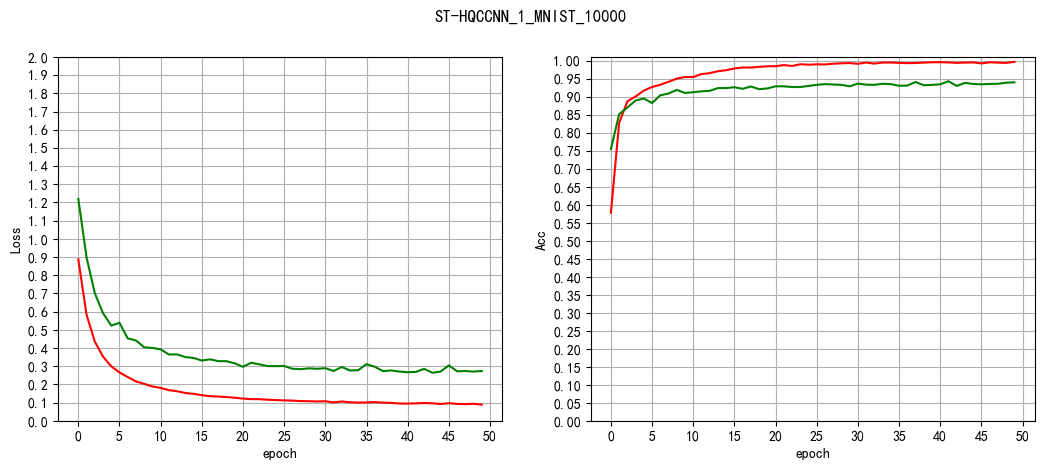

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("ST-HQCCNN_1_MNIST_10000", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 2.0001, 0.1))
plt.ylim(0, 2)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.00, 1.01, 0.05))
plt.ylim(0.00, 1.01)

plt.show()


In [17]:
model_Q = DressedQuantumNet_S()
model_Q = torch.load('Result/ST-HQCCNN_1_MNIST_10000.pth', map_location=device)
model_Q.eval()

DressedQuantumNet_S(
  (flat_net): Flatten(start_dim=1, end_dim=-1)
  (pre_net): Linear(in_features=784, out_features=256, bias=True)
  (post_net): Linear(in_features=4, out_features=10, bias=True)
)

In [18]:
print('ST-HQCCNN_1_MNIST_10000')

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集2000：')
print(totel_acc/test_data_size)

ST-HQCCNN_1_MNIST_10000
测试集2000：
0.943
